# Model Analysis and Visualization

This notebook loads a pre-trained model checkpoint and explores the results.

**Note**: Model training is now done via `train_model.py`. This notebook is for visualization only.

In [1]:
from rugby_ranking.notebook_utils import (
    setup_notebook_environment,
    load_model_and_trace,
    get_top_players,
    print_summary,
)
from rugby_ranking.model.predictions import MatchPredictor
import arviz as az

# Setup: load data and configure plots
dataset, df, model_dir = setup_notebook_environment()

Loading from: /home/daniel/repositories/personal/Rugby-Data
Unknown format in /home/daniel/repositories/personal/Rugby-Data/json/six-nations-2025-2026.json, skipping
Unknown format in /home/daniel/repositories/personal/Rugby-Data/json/six-nations-2026-2027.json, skipping
Loaded 10511 matches from /home/daniel/repositories/personal/Rugby-Data/json
Found 11846 unique players
Found 137 unique teams
✓ Loaded 392,160 player-match observations
  Players: 11,830
  Teams: 121
  Matches: 17,309
  Date range: 2006-09-02 to 2026-01-31


## 1. Load Pre-trained Model

Load a model checkpoint created by `train_model.py`.

In [5]:
# Load model checkpoint
CHECKPOINT_NAME = "joint_model_v3"  # Change this to load different checkpoints
model, trace = load_model_and_trace(CHECKPOINT_NAME)

print(f"\nModel configuration:")
print(f"  Time-varying effects: {model.config.time_varying_effects}")
print(f"  Separate kicking effect: {model.config.separate_kicking_effect}")
print(f"  Score types: {model.config.score_types}")

ℹ  Loading checkpoint: joint_model_v3
Loaded checkpoint from /home/daniel/.cache/rugby_ranking/joint_model_v3
✓ Loaded successfully
ℹ    Players: 13,786
ℹ    Team-seasons: 1126

Model configuration:
  Time-varying effects: False
  Separate kicking effect: True
  Score types: ('tries', 'penalties', 'conversions', 'drop_goals')


## 2. Load Data for Context

Load the original data to get match context (for filtering, player lookups, etc.)

In [3]:
# Data is already loaded in cell 1. Display summary:
print_summary(df, "Loaded Dataset")

Loaded Dataset
Records: 392,160
Players: 11,830
Teams: 121
Seasons: 20
Matches: 17,309
Date range: 2006-09-02 to 2026-01-31


In [6]:
# Model summary from trace
import arviz as az

summary = az.summary(trace, var_names=["sigma_player_try", "sigma_player_kick", "sigma_team", "alpha"])
print("\nKey parameters:")
print(summary)

print(f"\nPosterior samples: {trace.posterior.dims["draw"]} draws × {trace.posterior.dims["chain"]} chains")

arviz - WARNING - Shape validation failed: input_shape: (1, 2000), minimum_shape: (chains=2, draws=4)



Key parameters:
                    mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  \
sigma_player_try   0.638  0.007   0.626    0.652      0.000    0.000   
sigma_player_kick  1.012  0.002   1.009    1.015      0.000    0.000   
sigma_team         0.980  0.008   0.965    0.995      0.000    0.000   
alpha[0]          -2.347  0.005  -2.357   -2.336      0.000    0.000   
alpha[1]          -4.552  0.007  -4.566   -4.539      0.000    0.000   
alpha[2]          -3.640  0.006  -3.652   -3.628      0.000    0.000   
alpha[3]          -8.367  0.046  -8.452   -8.284      0.001    0.001   

                   ess_bulk  ess_tail  r_hat  
sigma_player_try     1843.0    1721.0    NaN  
sigma_player_kick    1930.0    2117.0    NaN  
sigma_team           1836.0    2047.0    NaN  
alpha[0]             2046.0    1887.0    NaN  
alpha[1]             1872.0    1931.0    NaN  
alpha[2]             2069.0    1842.0    NaN  
alpha[3]             1887.0    1848.0    NaN  

Posterior samples: 2000 draws

### Alternative: Full MCMC (slower but more accurate)

Uncomment to run full MCMC sampling. This takes longer but provides better uncertainty estimates.

In [5]:
# # Full MCMC (uncomment to run)
# inference_config = InferenceConfig(
#     mcmc_draws=1000,
#     mcmc_tune=500,
#     mcmc_chains=4,
#     mcmc_cores=4,
# )
# fitter = ModelFitter(model, inference_config)
# trace = fitter.fit_mcmc()

## 3. Model Diagnostics

Check convergence and model fit from the loaded checkpoint.

In [ ]:
# Compute diagnostics from trace
import arviz as az

def compute_diagnostics(trace):
    """Compute diagnostics from trace."""
    summary = az.summary(trace)
    return {
        "r_hat_max": summary["r_hat"].max(),
        "r_hat_mean": summary["r_hat"].mean(),
        "ess_bulk_min": summary["ess_bulk"].min(),
        "ess_tail_min": summary["ess_tail"].min(),
    }

diag = compute_diagnostics(trace)
print("Convergence Diagnostics:")
print(f"  R-hat (max): {diag["r_hat_max"]:.3f} (should be < 1.01)")
print(f"  R-hat (mean): {diag["r_hat_mean"]:.3f}")
print(f"  ESS bulk (min): {diag["ess_bulk_min"]:.0f} (should be > 400)")
print(f"  ESS tail (min): {diag["ess_tail_min"]:.0f} (should be > 400)")

In [ ]:
# ArviZ summary for key parameters
# For joint model, show parameters across score types

summary = az.summary(trace) #, var_names=['alpha', 'eta_home', 'sigma_player', 'sigma_team', 'lambda_player', 'lambda_team'])
display(summary)

KeyError: 'var names: "[\'sigma_player\' \'lambda_player\'] are not present" in dataset'

KeyError: 'var names: "[\'sigma_player\'] are not present" in dataset'

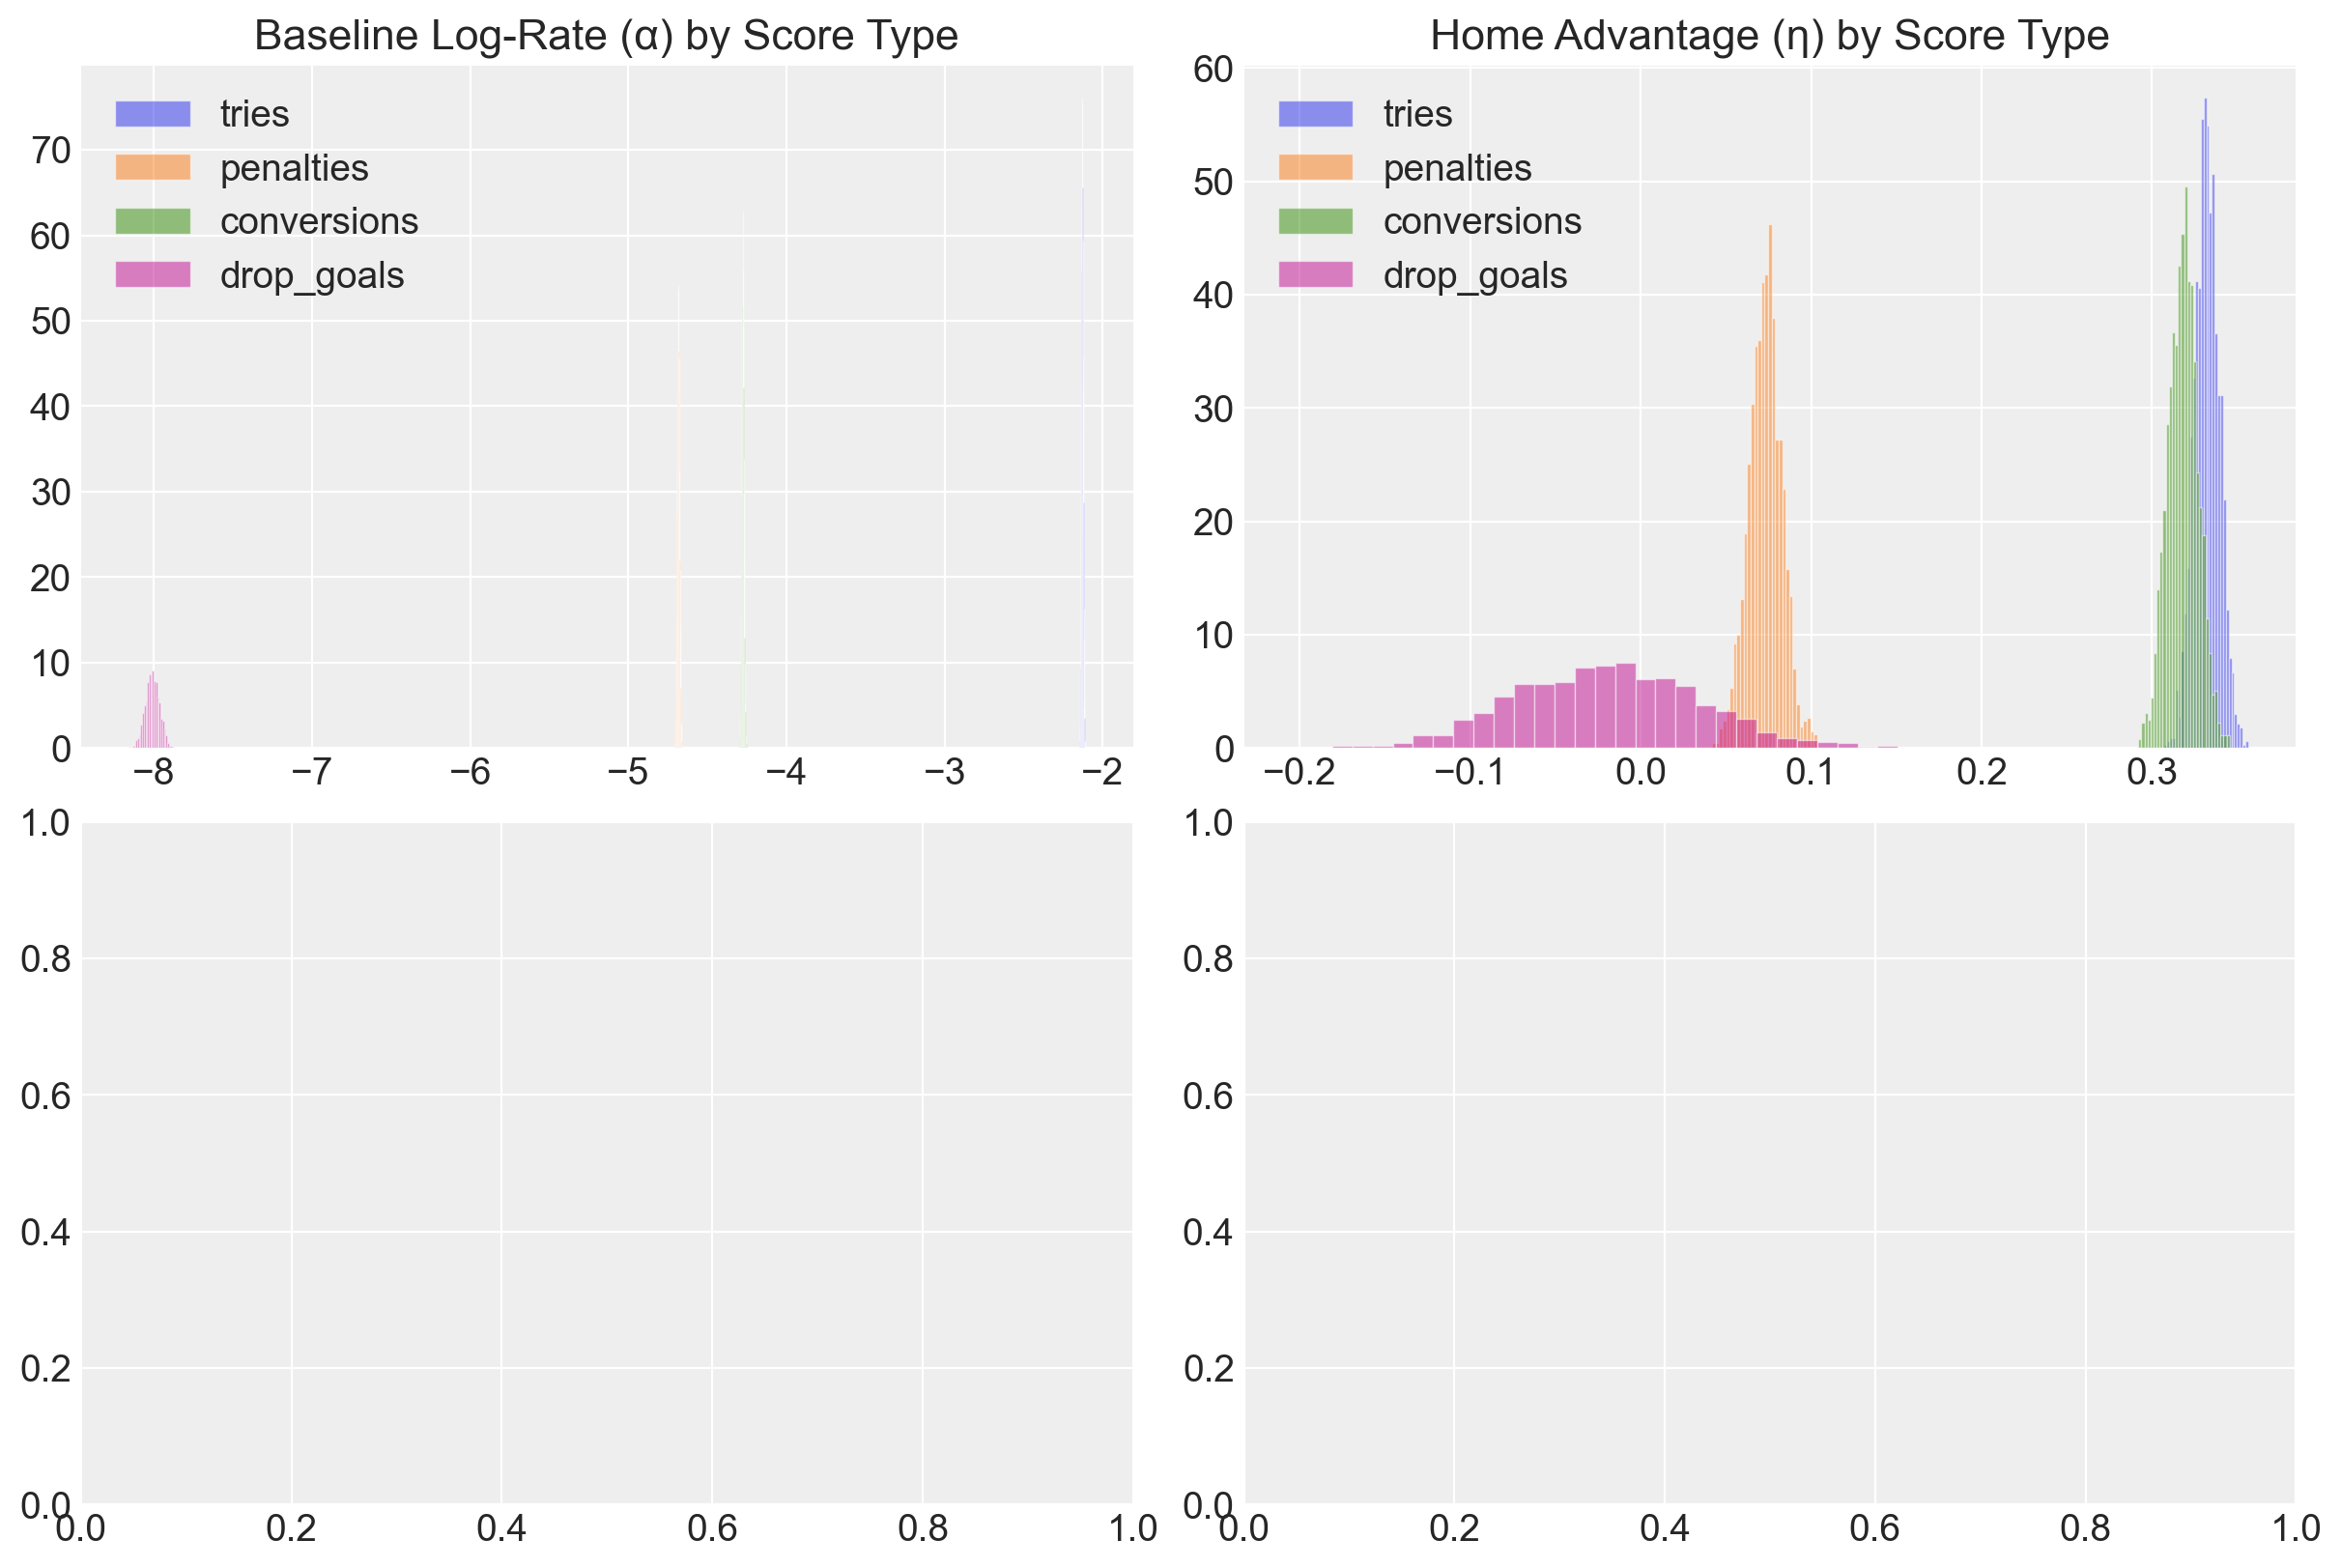

In [8]:
# Posterior distributions for global parameters
fig, axes = plt.subplots(2, 2, figsize=(12, 8))

# Alpha (baseline rates) for each score type
alpha = trace.posterior['alpha'].values
score_types = config.score_types
for i, st in enumerate(score_types):
    axes[0, 0].hist(alpha[:, :, i].flatten(), bins=30, alpha=0.5, label=st, density=True)
axes[0, 0].set_title('Baseline Log-Rate (α) by Score Type')
axes[0, 0].legend()

# Home advantage for each score type
eta = trace.posterior['eta_home'].values
for i, st in enumerate(score_types):
    axes[0, 1].hist(eta[:, :, i].flatten(), bins=30, alpha=0.5, label=st, density=True)
axes[0, 1].set_title('Home Advantage (η) by Score Type')
axes[0, 1].legend()

az.plot_posterior(trace, var_names=['sigma_player'], ax=axes[1, 0])
axes[1, 0].set_title('Player Effect SD (σ_player)')

az.plot_posterior(trace, var_names=['sigma_team'], ax=axes[1, 1])
axes[1, 1].set_title('Team Effect SD (σ_team)')

plt.tight_layout()
plt.show()

## 4. Player Rankings

The joint model lets us rank players by different scoring abilities. We can look at:
- **Tries**: Overall try-scoring ability
- **Penalties**: Kicking ability (fly-halves, fullbacks)
- **Conversions**: Conversion rate after tries
- **Drop goals**: Rare but valuable skill

In [33]:
# Rankings for each score type
def show_rankings(score_type, top_n=20, min_scores=5):
    """Display top players for a given score type."""
    rankings = model.get_player_rankings(
        trace=trace,
        top_n=top_n,
        score_type=score_type,
        df=df,
        min_scores=min_scores
    )
    print(f"\nTop {top_n} {score_type.capitalize()} Players (minimum {min_scores} {score_type}):")
    display(rankings)
    return rankings

# Try scorers - require at least 10 tries
try_rankings = show_rankings('tries', top_n=25, min_scores=10)

# Kickers (penalties and conversions) - require at least 20 kicks
penalty_rankings = show_rankings('penalties', top_n=20, min_scores=20)
conversion_rankings = show_rankings('conversions', top_n=20, min_scores=20)



Top 25 Tries Players (minimum 10 tries):


,player,effect_mean,effect_std,effect_lower,effect_upper,total_scores
0,Ed Byrne,1.724163,0.197354,1.333805,2.111907,38
1,Rob Evans,1.608738,0.161469,1.307613,1.940161,50
2,S Simmonds,1.554296,0.148448,1.263188,1.839478,61
3,Reinach Venter,1.531426,0.376152,0.802273,2.263833,13
4,Thomas Moukoro,1.524428,0.276644,0.995512,2.079999,18
5,Baptiste Couilloud,1.186934,0.135050,0.917386,1.456737,65
6,Mako Vunipola,1.151824,0.144056,0.871266,1.428495,58
7,Thomas du Toit,1.146173,0.227002,0.703472,1.583442,25
8,Dylan Evans,1.131827,0.335696,0.479091,1.785053,12
9,Alex Dombrandt,1.130156,0.122986,0.899126,1.383254,81



Top 20 Penalties Players (minimum 20 penalties):


,player,effect_mean,effect_std,effect_lower,effect_upper,total_scores
0,Joseph Davies,7.939174,0.174689,7.583774,8.296560,27
1,Ed Byrne,7.720362,0.098691,7.518421,7.913427,52
2,S Simmonds,7.199635,0.103911,7.000450,7.399988,46
3,Joe Davies,7.044438,0.173694,6.705260,7.387862,27
4,Daniel Du Preez,6.775418,0.152485,6.485020,7.076070,33
5,Taylor Davies,6.668927,0.240359,6.211787,7.135915,20
6,Wyn Jones,6.558118,0.149246,6.273665,6.856760,44
7,Marc Jones,6.325207,0.171053,6.004338,6.666750,31
8,Gaetan Germain,6.126310,0.145951,5.839025,6.411304,43
9,Thomas Girard,6.048739,0.104201,5.841991,6.249011,91



Top 20 Conversions Players (minimum 20 conversions):


,player,effect_mean,effect_std,effect_lower,effect_upper,total_scores
0,Joseph Davies,5.583835,0.122717,5.339163,5.831089,30
1,Ed Byrne,5.429945,0.069697,5.288217,5.563020,141
2,S Simmonds,5.063703,0.073340,4.922447,5.206165,136
3,Joe Davies,4.954553,0.122467,4.714527,5.197599,35
4,Daniel Du Preez,4.765332,0.107051,4.559675,4.973499,55
5,Taylor Davies,4.690461,0.169684,4.368788,5.017985,26
6,Wyn Jones,4.612510,0.105233,4.409328,4.827695,42
7,Mornay Smith,4.609925,0.175955,4.255290,4.938713,20
8,Marc Jones,4.448718,0.121301,4.216523,4.688385,33
9,Bryan Byrne,4.434119,0.118698,4.195136,4.666197,60


/tmp/ipykernel_1316/4173634301.py:23: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


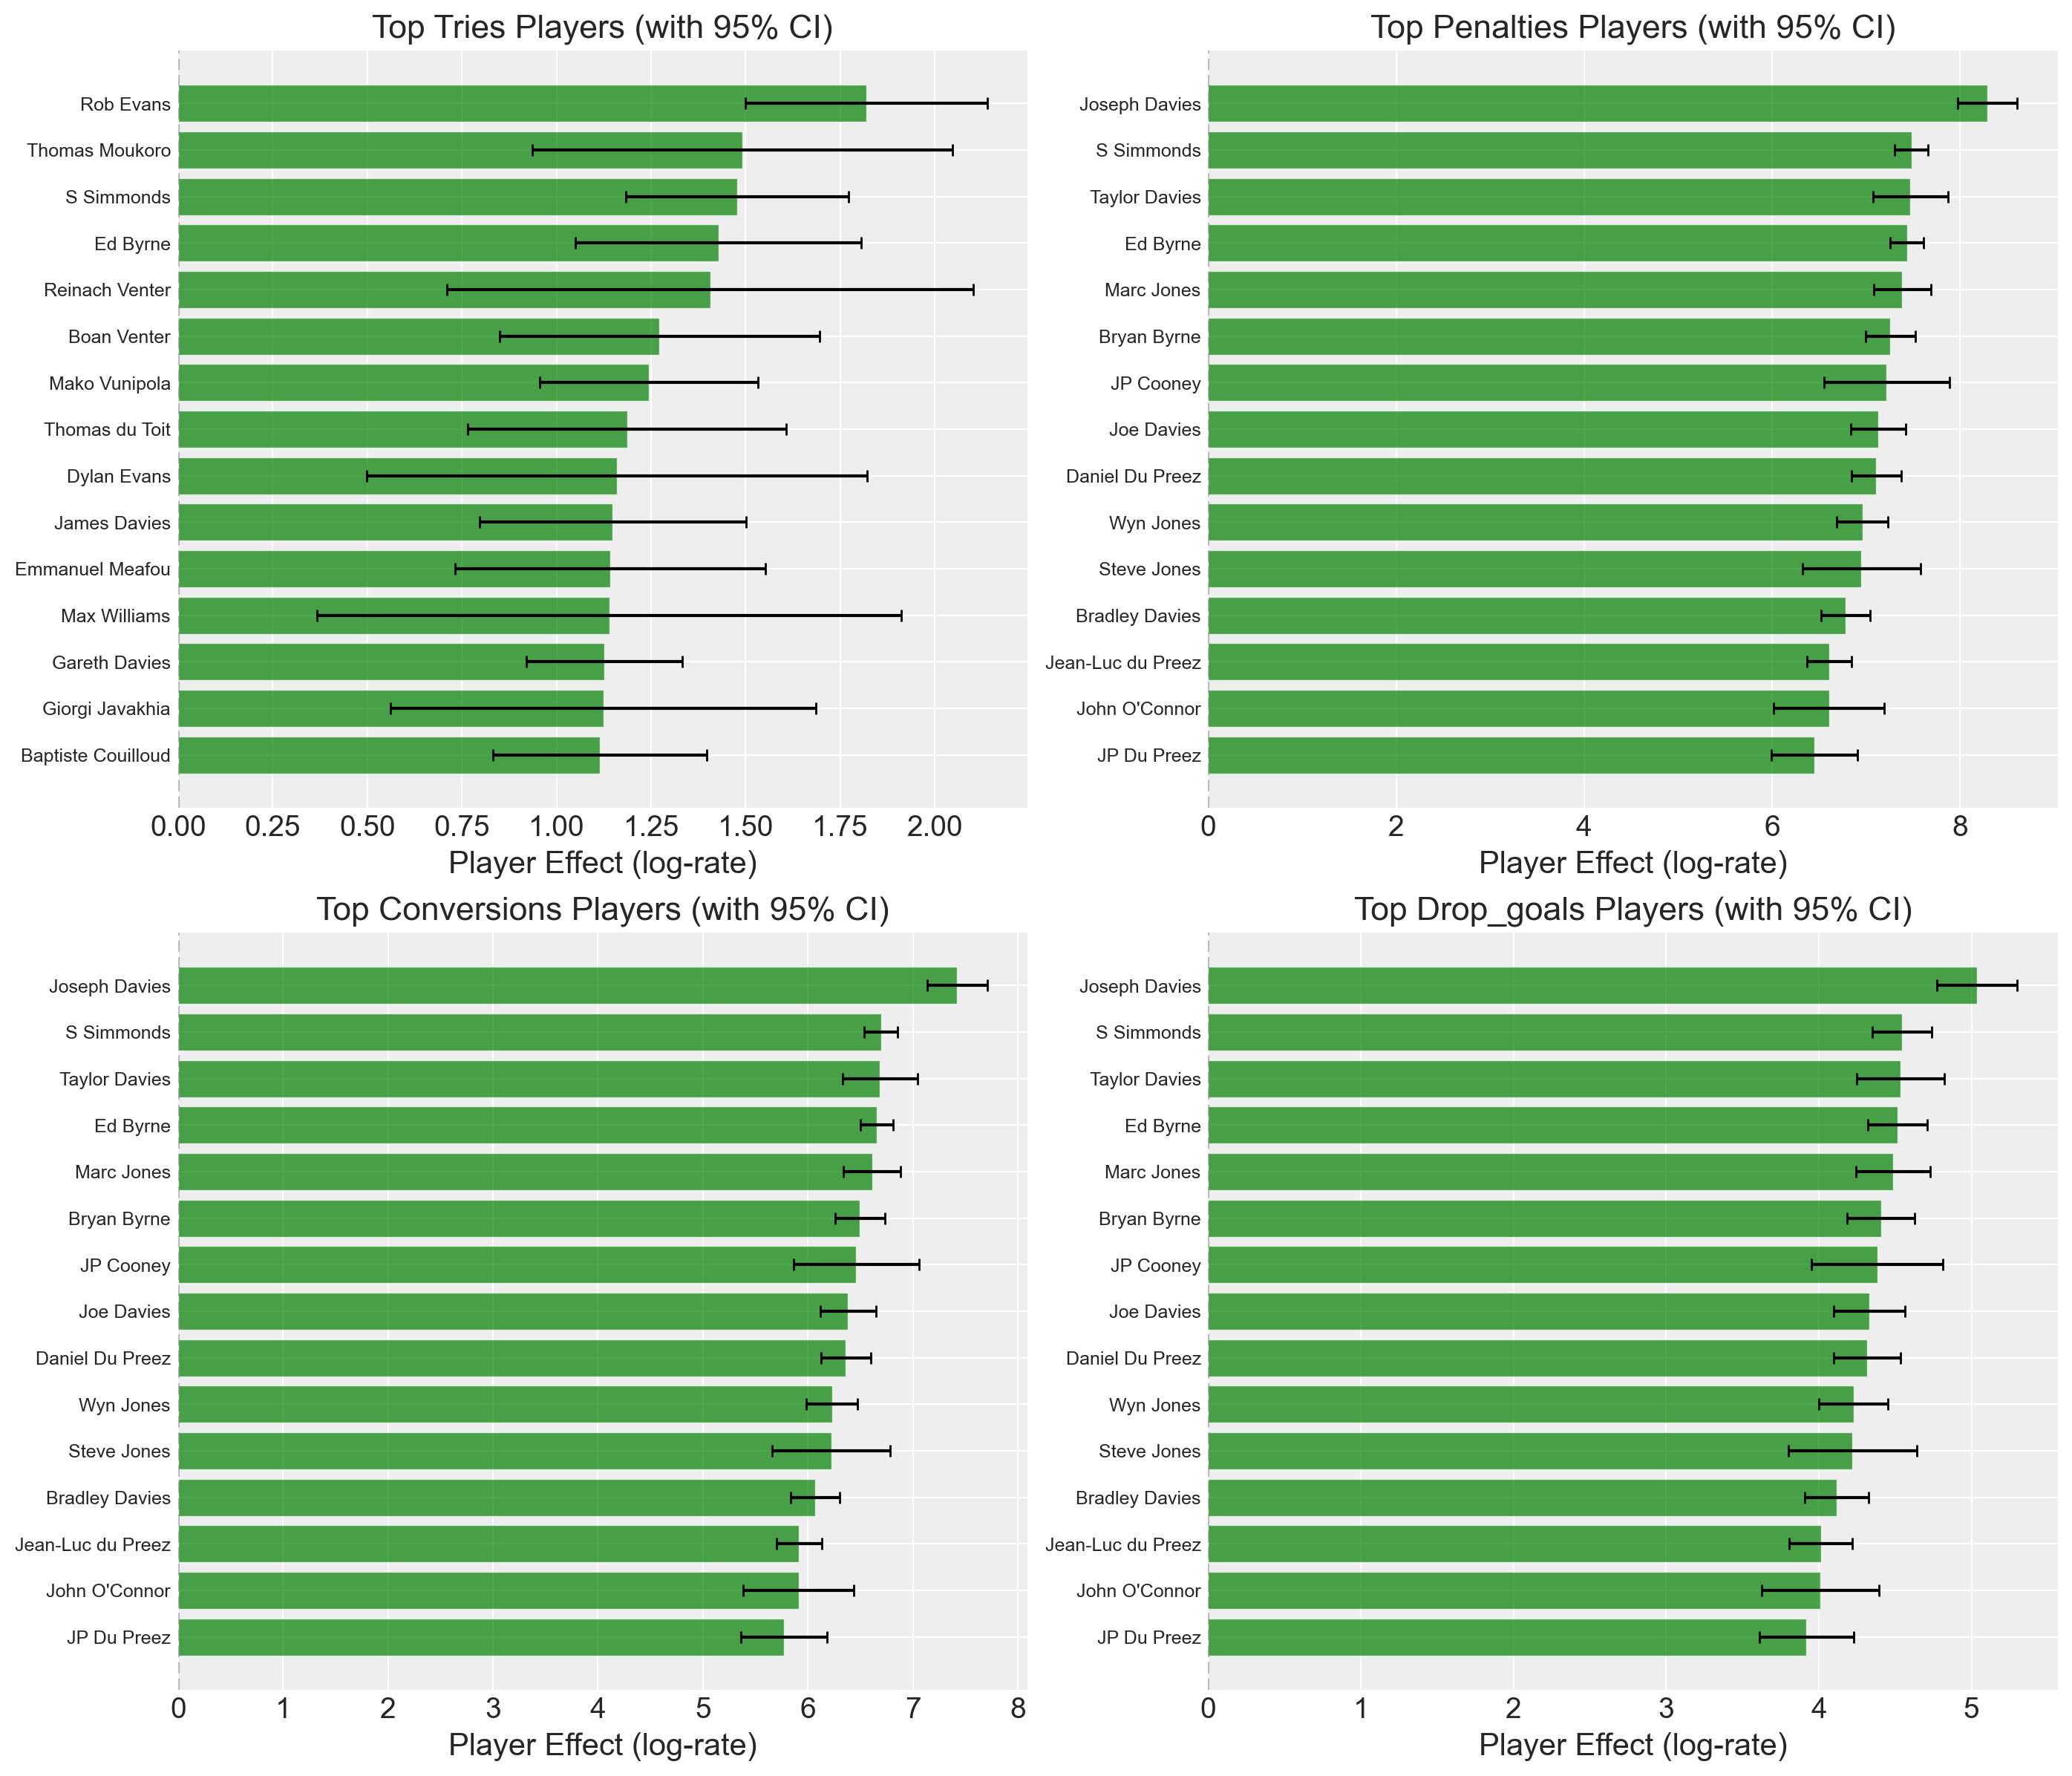

In [10]:
# Visualize top players for each score type
fig, axes = plt.subplots(2, 2, figsize=(14, 12))

for ax, score_type in zip(axes.flat, config.score_types):
    # Set minimum thresholds per score type
    min_threshold = {'tries': 10, 'penalties': 20, 'conversions': 20, 'drop_goals': 2}.get(score_type, 5)
    rankings = model.get_player_rankings(
        trace=trace,
        top_n=15,
        score_type=score_type,
        df=df,
        min_scores=min_threshold
    )

    if len(rankings) == 0:
        ax.set_visible(False)
        continue

    y_pos = np.arange(len(rankings))
    colors = ['green' if x > 0 else 'red' for x in rankings['effect_mean']]

    ax.barh(y_pos, rankings['effect_mean'], xerr=rankings['effect_std'] * 1.96,
            align='center', alpha=0.7, capsize=3, color=colors)
    ax.set_yticks(y_pos)

    # Add score counts to labels if available
    if 'total_scores' in rankings.columns:
        labels = [f"{row['player']} ({int(row['total_scores'])})"
                  for _, row in rankings.iterrows()]
    else:
        labels = rankings['player'].tolist()

    ax.set_yticklabels(labels, fontsize=9)
    ax.invert_yaxis()
    ax.set_xlabel('Player Effect (log-rate)')
    ax.set_title(f'Top {score_type.capitalize()} Players (min {min_threshold}, with 95% CI)')
    ax.axvline(x=0, color='gray', linestyle='--', alpha=0.5)

plt.tight_layout()
plt.show()


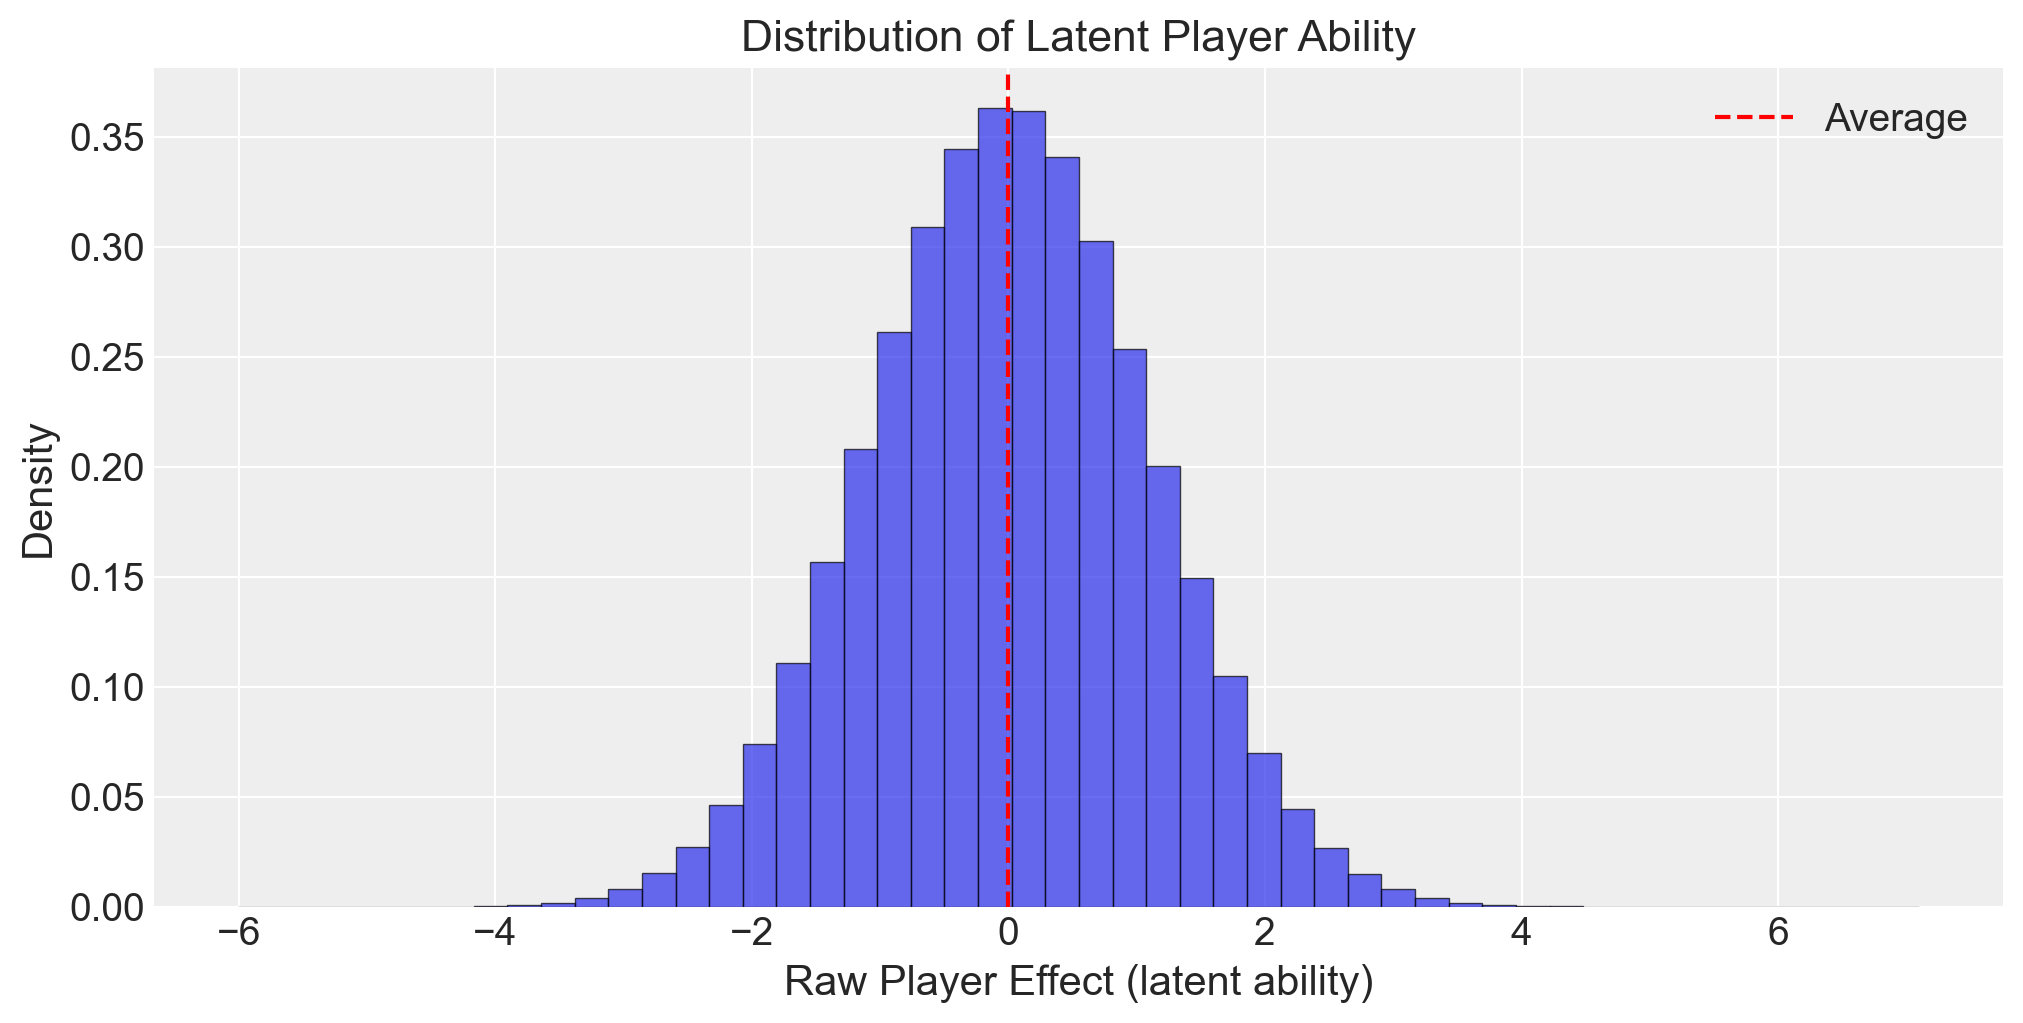

Raw player effect range: [-6.00, 7.10]
Raw player effect std: 1.090


In [35]:
# Player effect distribution (shared latent ability)
beta_raw = trace.posterior['beta_player_try_raw'].values.flatten()

fig, ax = plt.subplots(figsize=(10, 5))
ax.hist(beta_raw, bins=50, density=True, alpha=0.7, edgecolor='black')
ax.set_xlabel('Raw Player Effect (latent ability)')
ax.set_ylabel('Density')
ax.set_title('Distribution of Latent Player Ability')
ax.axvline(x=0, color='red', linestyle='--', label='Average')
ax.legend()
plt.show()

print(f"Raw player effect range: [{beta_raw.min():.2f}, {beta_raw.max():.2f}]")
print(f"Raw player effect std: {beta_raw.std():.3f}")

### Best Kickers

Let's look at players who excel at both penalties and conversions - the all-round kickers.

Top All-Round Kickers (Penalties + Conversions):


,player,effect_mean_pen,effect_mean_con,combined_effect,total_scores_pen,total_scores_con,total_kicks
0,Joseph Davies,7.939174,5.583835,13.523009,27,30,57
1,Ed Byrne,7.720362,5.429945,13.150306,52,141,193
2,S Simmonds,7.199635,5.063703,12.263339,46,136,182
3,Joe Davies,7.044438,4.954553,11.998990,27,35,62
4,Daniel Du Preez,6.775418,4.765332,11.540750,33,55,88
5,Taylor Davies,6.668927,4.690461,11.359388,20,26,46
6,Wyn Jones,6.558118,4.612510,11.170628,44,42,86
7,Marc Jones,6.325207,4.448718,10.773925,31,33,64
8,Gaetan Germain,6.126310,4.308821,10.435131,43,34,77
9,Thomas Girard,6.048739,4.254256,10.302995,91,47,138


/tmp/ipykernel_16317/658235358.py:53: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


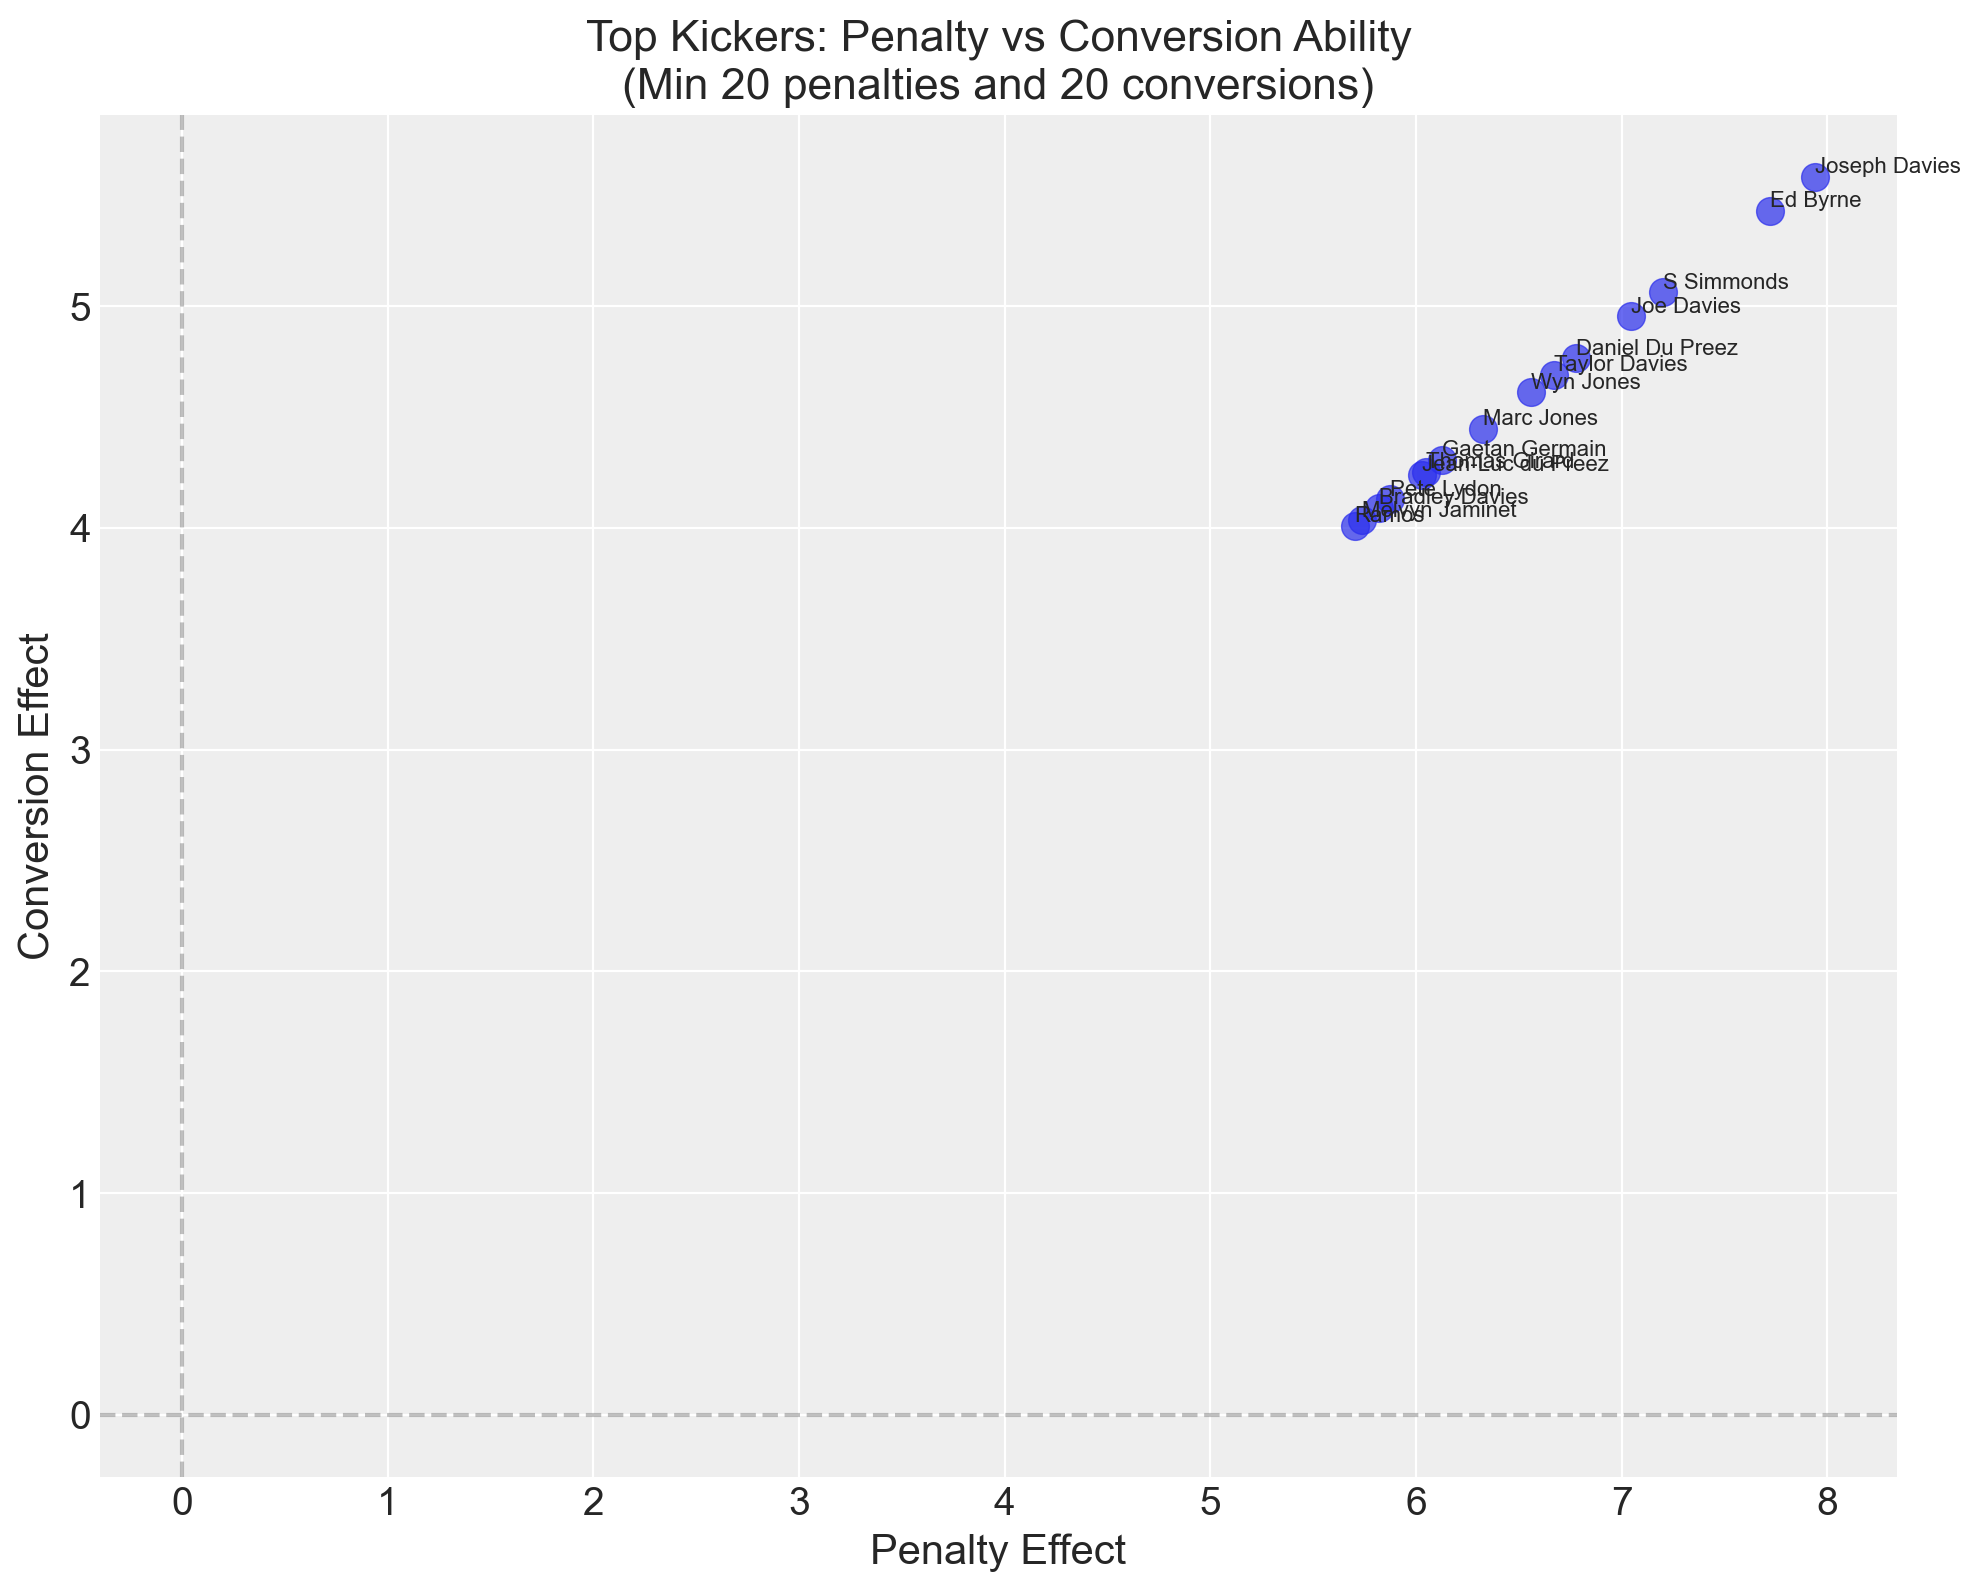

In [36]:
# Find all-round kickers (good at both penalties and conversions)
# Require minimum 20 penalties AND 20 conversions to be considered
pen_ranks = model.get_player_rankings(
    trace=trace,
    top_n=50,
    score_type='penalties',
    df=df,
    min_scores=20
)
con_ranks = model.get_player_rankings(
    trace=trace,
    top_n=50,
    score_type='conversions',
    df=df,
    min_scores=20
)

# Merge to find players good at both
kicker_df = pen_ranks.merge(con_ranks, on='player', suffixes=('_pen', '_con'))

# Combine score counts
if 'total_scores_pen' in kicker_df.columns and 'total_scores_con' in kicker_df.columns:
    kicker_df['total_kicks'] = kicker_df['total_scores_pen'] + kicker_df['total_scores_con']

kicker_df['combined_effect'] = kicker_df['effect_mean_pen'] + kicker_df['effect_mean_con']
kicker_df = kicker_df.sort_values('combined_effect', ascending=False)

print("Top All-Round Kickers (Penalties + Conversions):")
if 'total_kicks' in kicker_df.columns:
    display(kicker_df[['player', 'effect_mean_pen', 'effect_mean_con',
                       'combined_effect', 'total_scores_pen', 'total_scores_con',
                       'total_kicks']].head(15))
else:
    display(kicker_df[['player', 'effect_mean_pen', 'effect_mean_con',
                       'combined_effect']].head(15))

# Visualize kicker comparison
fig, ax = plt.subplots(figsize=(10, 8))
top_kickers = kicker_df.head(15)

ax.scatter(top_kickers['effect_mean_pen'], top_kickers['effect_mean_con'],
           s=100, alpha=0.7)

for _, row in top_kickers.iterrows():
    ax.annotate(row['player'], (row['effect_mean_pen'], row['effect_mean_con']),
                fontsize=8, ha='left', va='bottom')

ax.axhline(y=0, color='gray', linestyle='--', alpha=0.5)
ax.axvline(x=0, color='gray', linestyle='--', alpha=0.5)
ax.set_xlabel('Penalty Effect')
ax.set_ylabel('Conversion Effect')
ax.set_title('Top Kickers: Penalty vs Conversion Ability\n(Min 20 penalties and 20 conversions)')
plt.tight_layout()
plt.show()


## 5. Team Rankings

In [38]:
# Get most recent season
seasons = sorted(model._season_ids.keys())
current_season = seasons[-1] if seasons else None
current_season = "2025-2026"
print(f"Current season: {current_season}")

# Team rankings for current season
team_rankings = model.get_team_rankings(trace=trace, season=current_season, top_n=20)
display(team_rankings)

Current season: 2025-2026


,team,season,effect_mean,effect_std,effect_lower,effect_upper
0,All Blacks XV,2025-2026,0.865279,0.293544,0.311796,1.447304
1,Vannes,2025-2026,0.538937,0.085226,0.375831,0.705542
2,Biarritz,2025-2026,0.487197,0.088726,0.320409,0.661257
3,Oyonnax,2025-2026,0.470867,0.084757,0.306302,0.636039
4,Exeter Chiefs,2025-2026,0.424492,0.100148,0.227183,0.618968
5,Agen,2025-2026,0.344332,0.097303,0.151486,0.535157
6,Bristol Bears,2025-2026,0.303503,0.094669,0.122165,0.487708
7,Bath Rugby,2025-2026,0.233524,0.092752,0.045248,0.414487
8,Aurillac,2025-2026,0.229243,0.092239,0.052026,0.408856
9,Mont-de-Marsan,2025-2026,0.228145,0.104073,0.031417,0.436363


/tmp/ipykernel_16317/4259130998.py:17: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


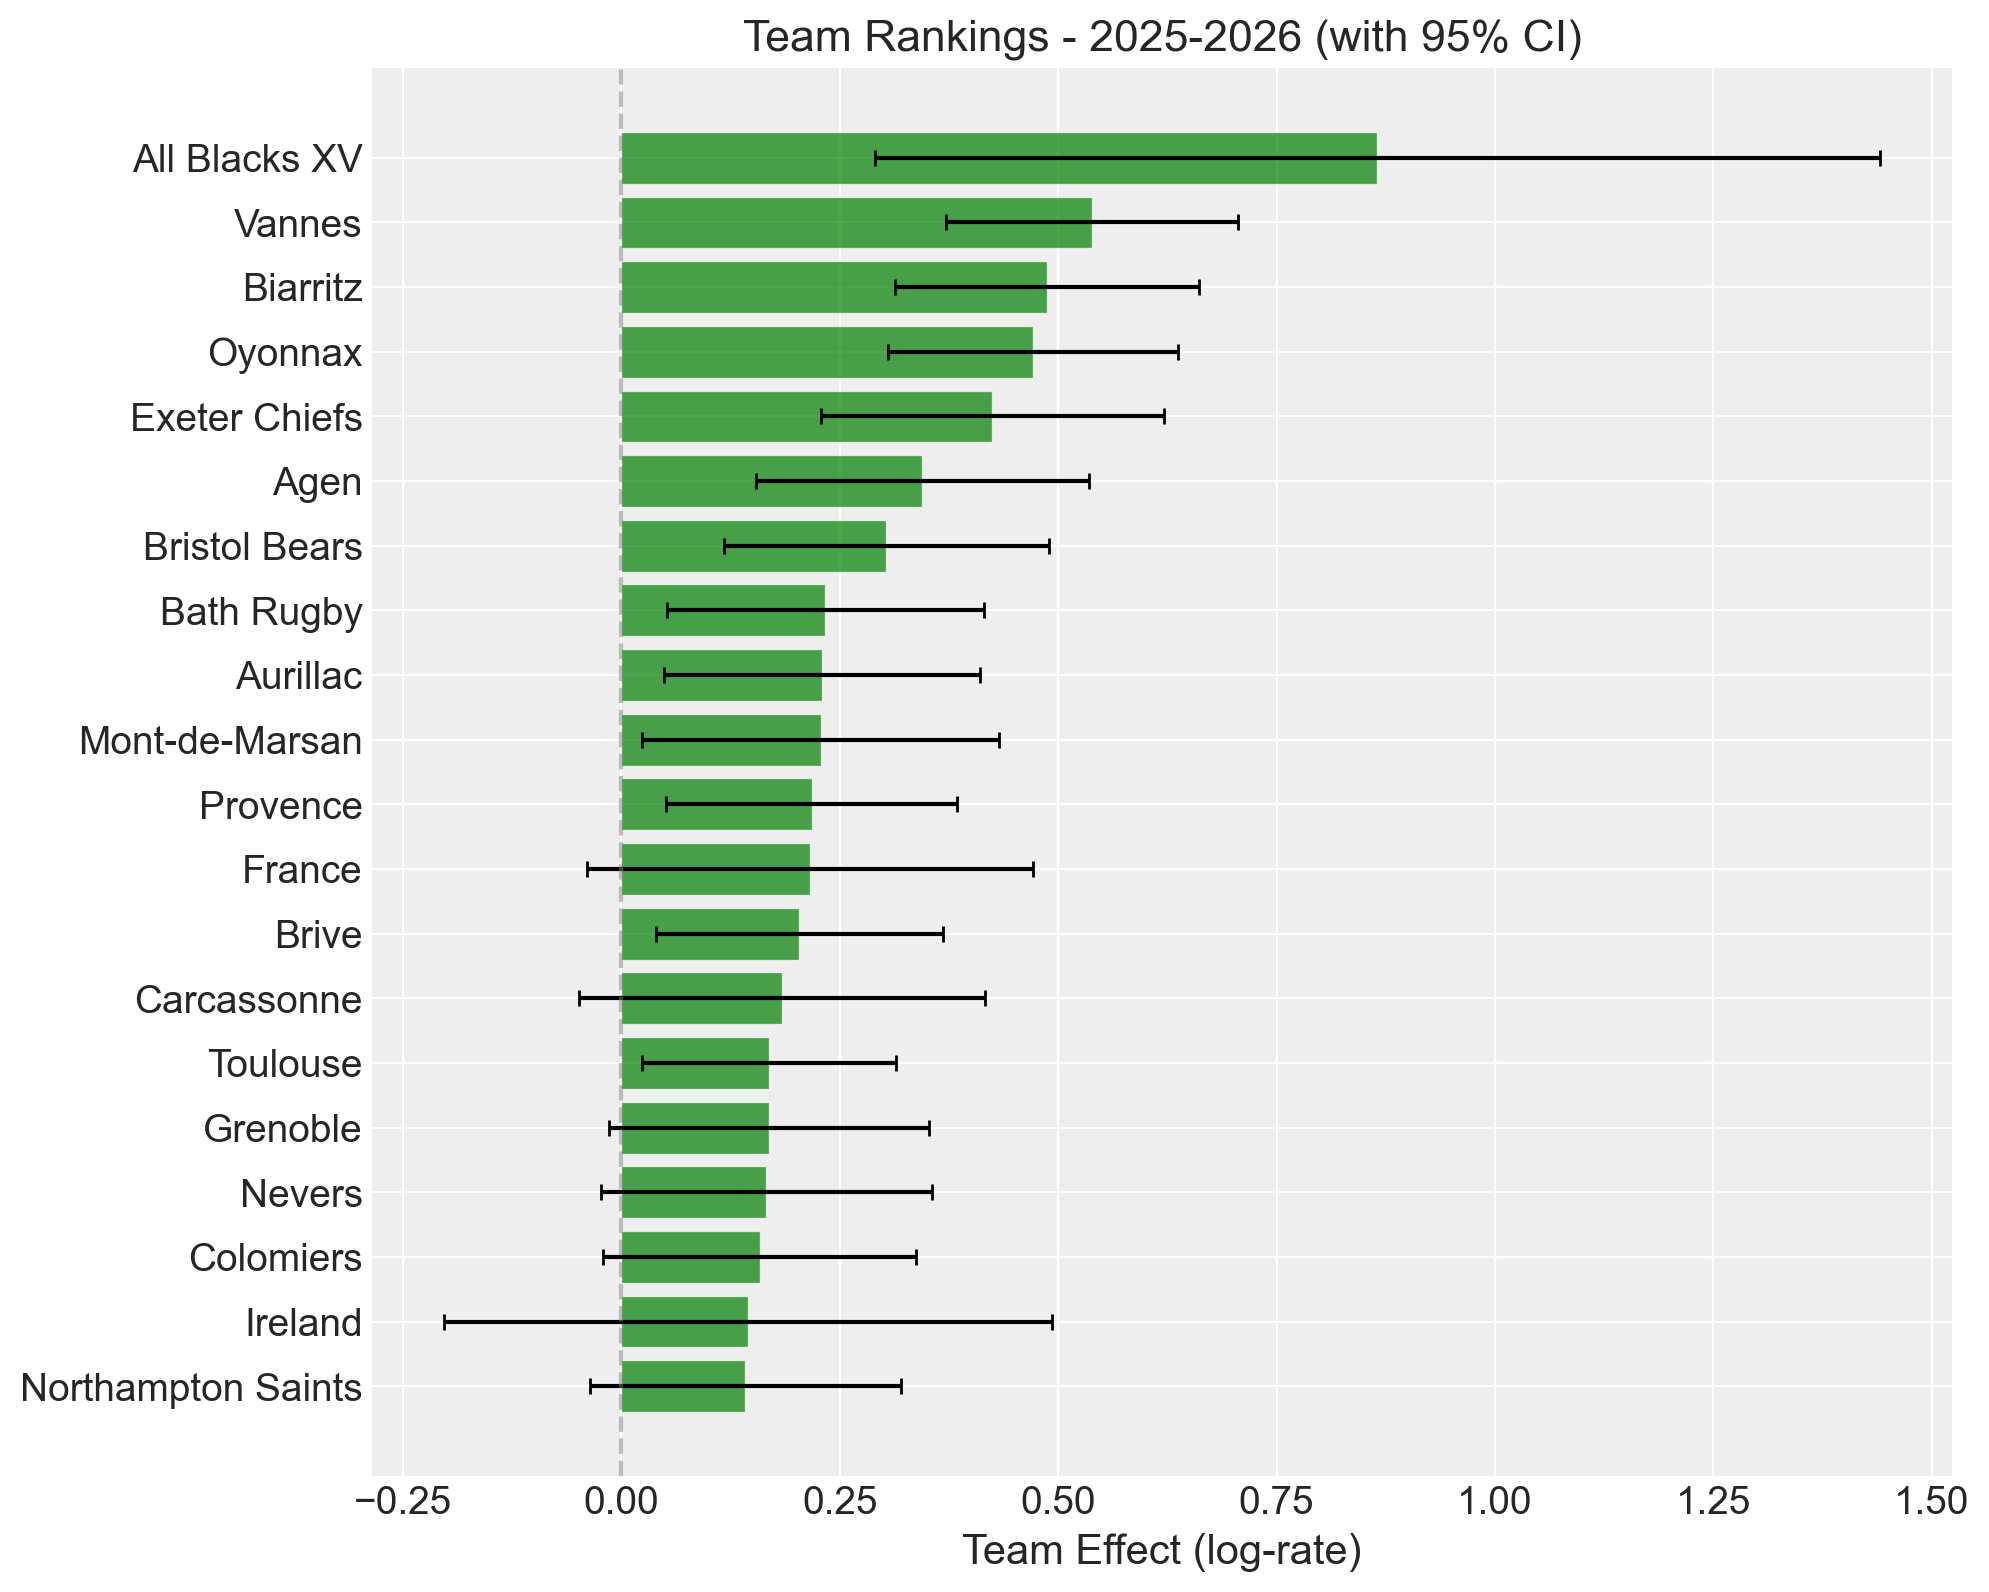

In [39]:
# Visualize team rankings
if len(team_rankings) > 0:
    fig, ax = plt.subplots(figsize=(10, 8))
    
    y_pos = np.arange(len(team_rankings))
    colors = ['green' if x > 0 else 'red' for x in team_rankings['effect_mean']]
    
    ax.barh(y_pos, team_rankings['effect_mean'], xerr=team_rankings['effect_std'] * 1.96,
            align='center', alpha=0.7, capsize=3, color=colors)
    ax.set_yticks(y_pos)
    ax.set_yticklabels(team_rankings['team'])
    ax.invert_yaxis()
    ax.set_xlabel('Team Effect (log-rate)')
    ax.set_title(f'Team Rankings - {current_season} (with 95% CI)')
    ax.axvline(x=0, color='gray', linestyle='--', alpha=0.5)
    
    plt.tight_layout()
    plt.show()

## 6. Position Effects

/tmp/ipykernel_16317/2472324956.py:30: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


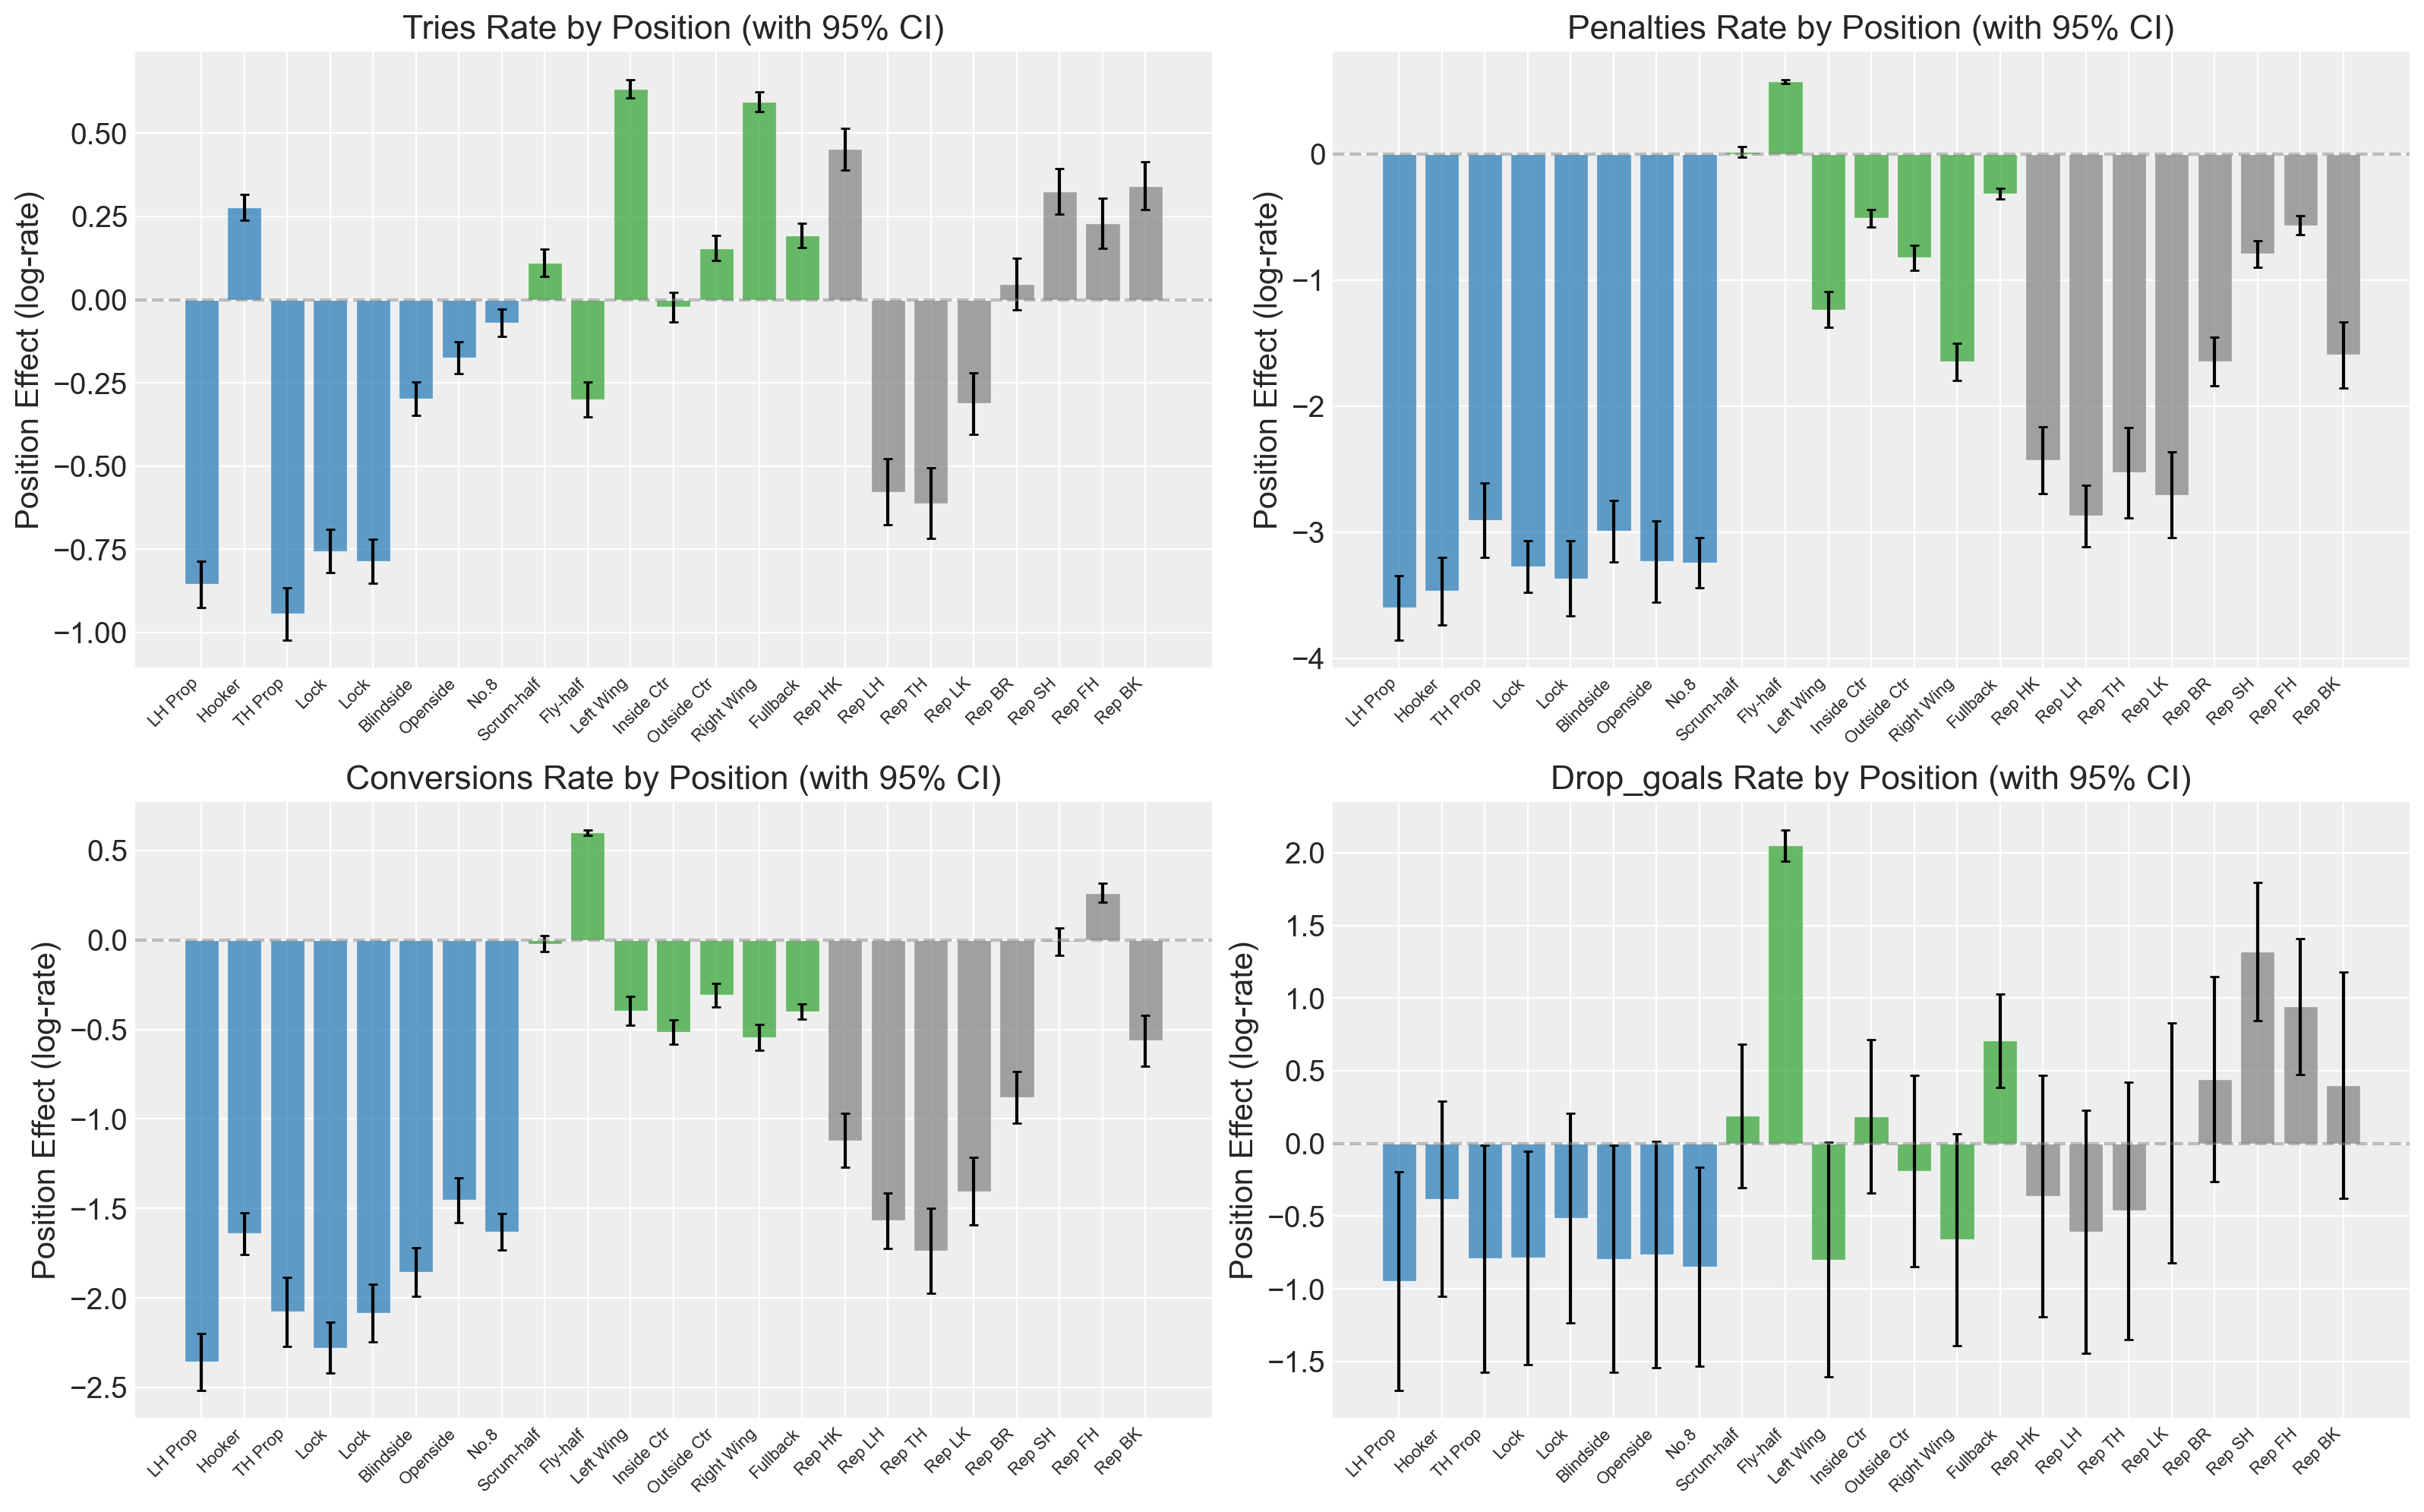

In [43]:
# Extract position effects for each score type
theta = trace.posterior['theta_position'].values  # (chain, draw, n_score_types, n_positions)

positions = {
    1: 'LH Prop', 2: 'Hooker', 3: 'TH Prop',
    4: 'Lock', 5: 'Lock', 6: 'Blindside', 7: 'Openside', 8: 'No.8',
    9: 'Scrum-half', 10: 'Fly-half', 11: 'Left Wing',
    12: 'Inside Ctr', 13: 'Outside Ctr', 14: 'Right Wing', 15: 'Fullback',
    16: 'Rep HK', 17: 'Rep LH', 18: 'Rep TH', 19: 'Rep LK', 20: 'Rep BR',
    21: 'Rep SH', 22: 'Rep FH', 23: 'Rep BK'
}

# Plot position effects for tries vs kicks
fig, axes = plt.subplots(2, 2, figsize=(16, 10))

for s, (st, ax) in enumerate(zip(config.score_types, axes.flat)):
    theta_mean = theta[:, :, s, :23].mean(axis=(0, 1))
    theta_std = theta[:, :, s, :23].std(axis=(0, 1))
    
    x_pos = np.arange(23)
    colors = ['#1f77b4' if i < 8 else '#2ca02c' if i < 15 else '#7f7f7f' for i in range(23)]
    
    ax.bar(x_pos, theta_mean, yerr=theta_std * 1.96, capsize=2, alpha=0.7, color=colors)
    ax.set_xticks(x_pos)
    ax.set_xticklabels([positions.get(i+1, str(i+1)) for i in range(23)], rotation=45, ha='right', fontsize=8)
    ax.set_ylabel('Position Effect (log-rate)')
    ax.set_title(f'{st.capitalize()} Rate by Position (with 95% CI)')
    ax.axhline(y=0, color='gray', linestyle='--', alpha=0.5)

plt.tight_layout()
plt.show()

## 7. Match Predictions

In [51]:
# Create predictor
predictor = MatchPredictor(model, trace)

# Example: Predict Leinster vs Munster
seasons = sorted(model._season_ids.keys())
current_season = seasons[-1] if seasons else "2024-2025"

try:
    prediction = predictor.predict_teams_only(
        home_team="Leinster",
        away_team="Munster",
        season=current_season,
    )
    print(prediction.summary())
except ValueError as e:
    print(f"Error: {e}")
    print("\nTip: Update team names to match teams in your loaded model")

Teams in 2025-2026: ['Wales', 'France', 'Scotland', 'Italy', 'Ireland', 'England', '', 'British & Irish Lions', 'Barbarians', 'Beziers']...


In [52]:
def quick_predict(home_team, away_team):

    # Predict a match (adjust team names as needed)
    if len(current_teams) >= 2:
        home_team = current_teams[current_teams.index(home_team)]
        away_team = current_teams[current_teams.index(away_team)]
        
        try:
            prediction = predictor.predict_teams_only(
                home_team=home_team,
                away_team=away_team,
                season=current_season,
                n_samples=2000
            )
            
            #print(prediction.summary())
            #print()
            #print(f"Detailed breakdown:")
            print(f"  Home ({home_team}): {prediction.home.mean:.1f} ± {prediction.home.std:.1f}", end='\t')
            print(f"  Away ({away_team}): {prediction.away.mean:.1f} ± {prediction.away.std:.1f}")
            #print(f"  90% CI Home: [{prediction.home.ci_lower:.0f}, {prediction.home.ci_upper:.0f}]")
            #print(f"  90% CI Away: [{prediction.away.ci_lower:.0f}, {prediction.away.ci_upper:.0f}]")
        except ValueError as e:
            print(f"Could not predict: {e}")

In [53]:
quick_predict("Glasgow Warriors", "Saracens")
#quick_predict("Pau", "Bulls")
#quick_predict("Dragons RFC", "Newcastle Red Bulls")
#quick_predict("Durban Sharks", "Newcastle Red Bulls")

  Home (Glasgow Warriors): 19.2 ± 10.6	  Away (Saracens): 17.8 ± 9.8


NameError: name 'prediction' is not defined

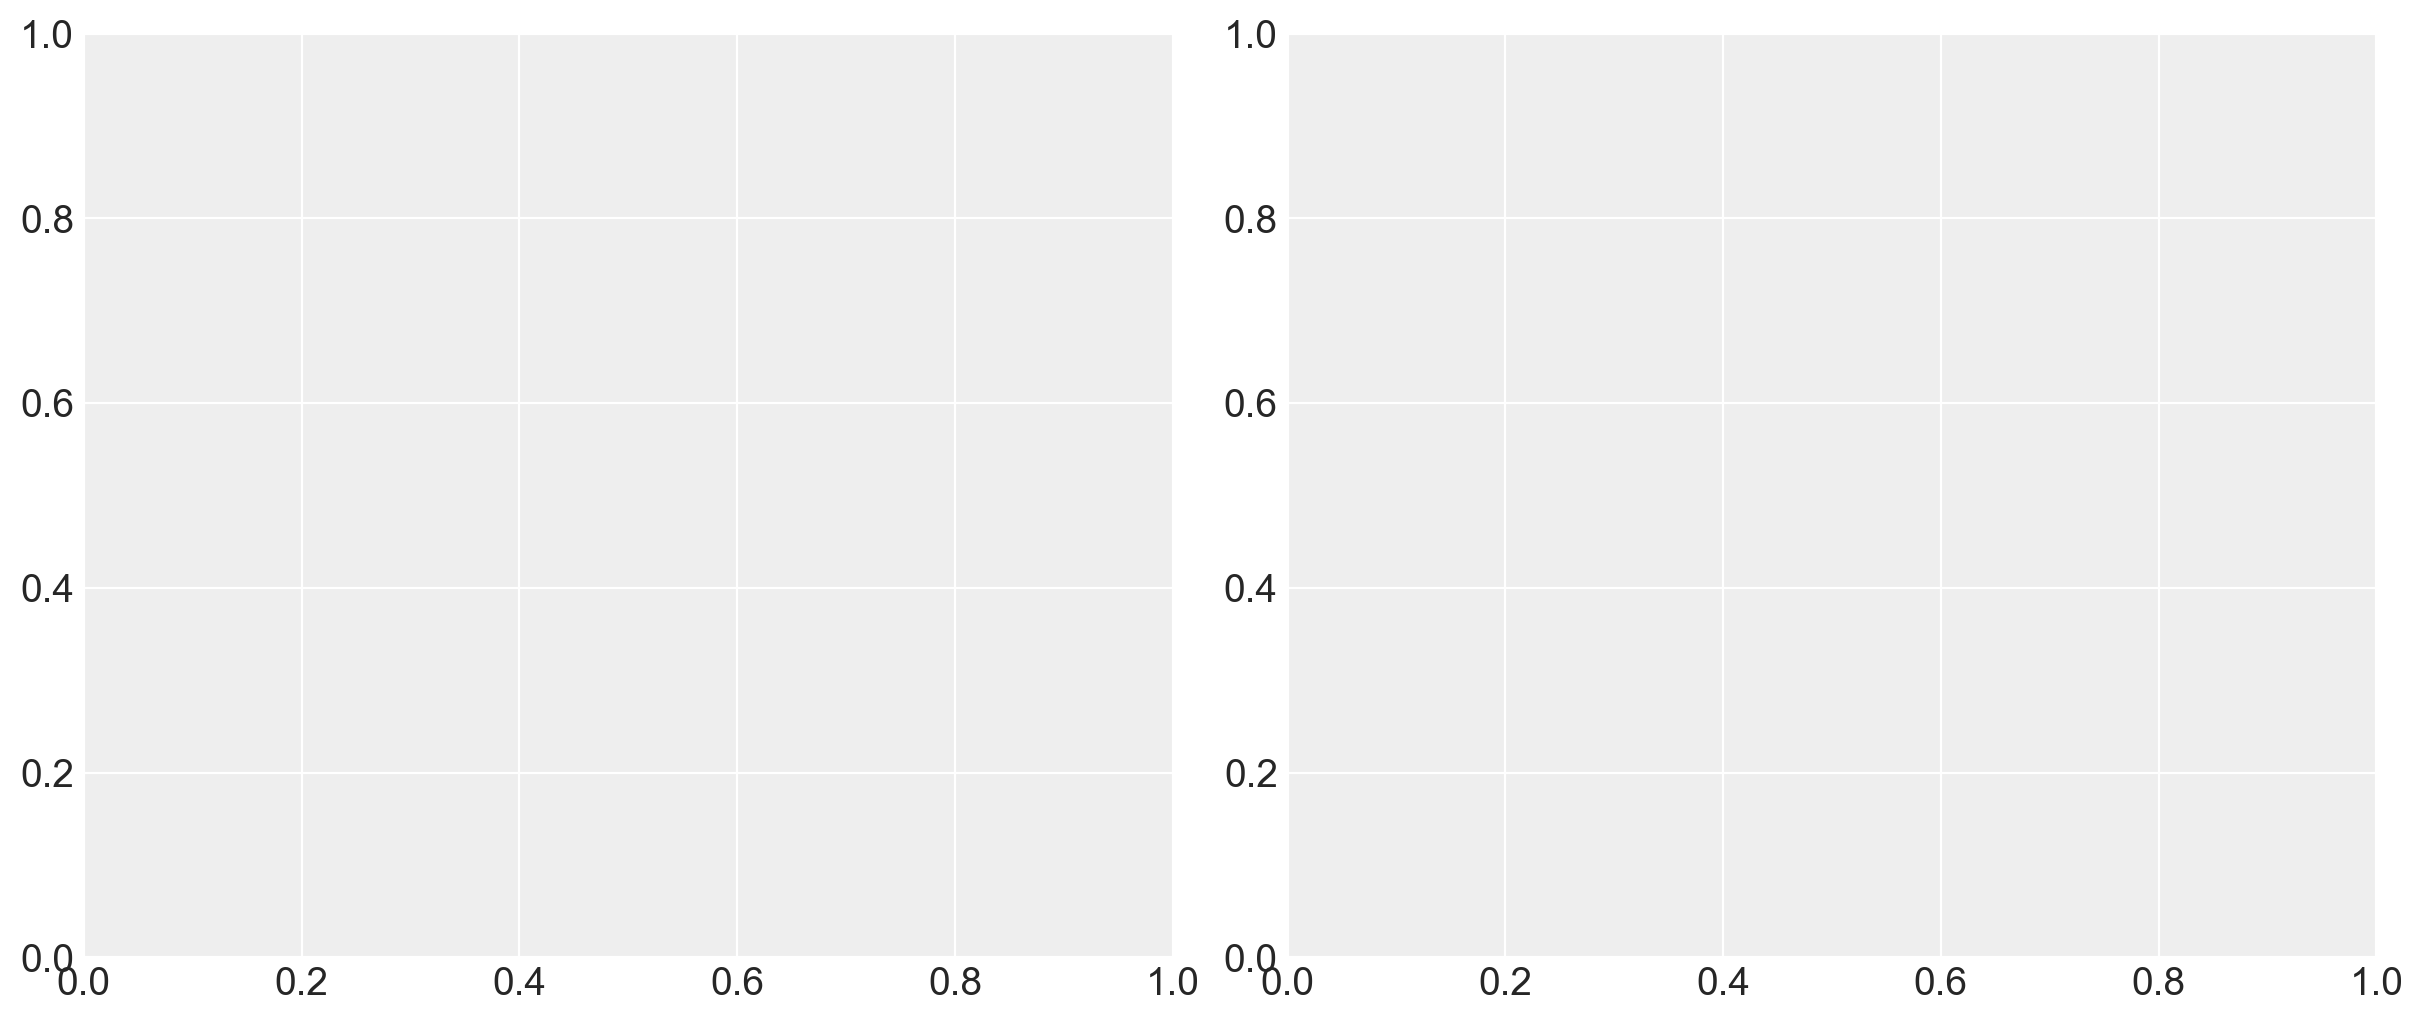

In [54]:
# Visualize score distributions
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# Score distributions
axes[0].hist(prediction.home.samples, bins=30, alpha=0.6, label=home_team, density=True)
axes[0].hist(prediction.away.samples, bins=30, alpha=0.6, label=away_team, density=True)
axes[0].set_xlabel('Predicted Score')
axes[0].set_ylabel('Density')
axes[0].set_title('Score Distributions')
axes[0].legend()

# Margin distribution
margin = prediction.home.samples - prediction.away.samples
axes[1].hist(margin, bins=40, alpha=0.7, color='purple', density=True)
axes[1].axvline(x=0, color='red', linestyle='--', label='Draw')
axes[1].axvline(x=margin.mean(), color='green', linestyle='-', label=f'Mean: {margin.mean():.1f}')
axes[1].set_xlabel('Margin (Home - Away)')
axes[1].set_ylabel('Density')
axes[1].set_title('Predicted Margin')
axes[1].legend()

plt.tight_layout()
plt.show()

## 8. Posterior Predictive Checks

Compare model predictions to observed data.

/tmp/ipykernel_16317/3411294937.py:36: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


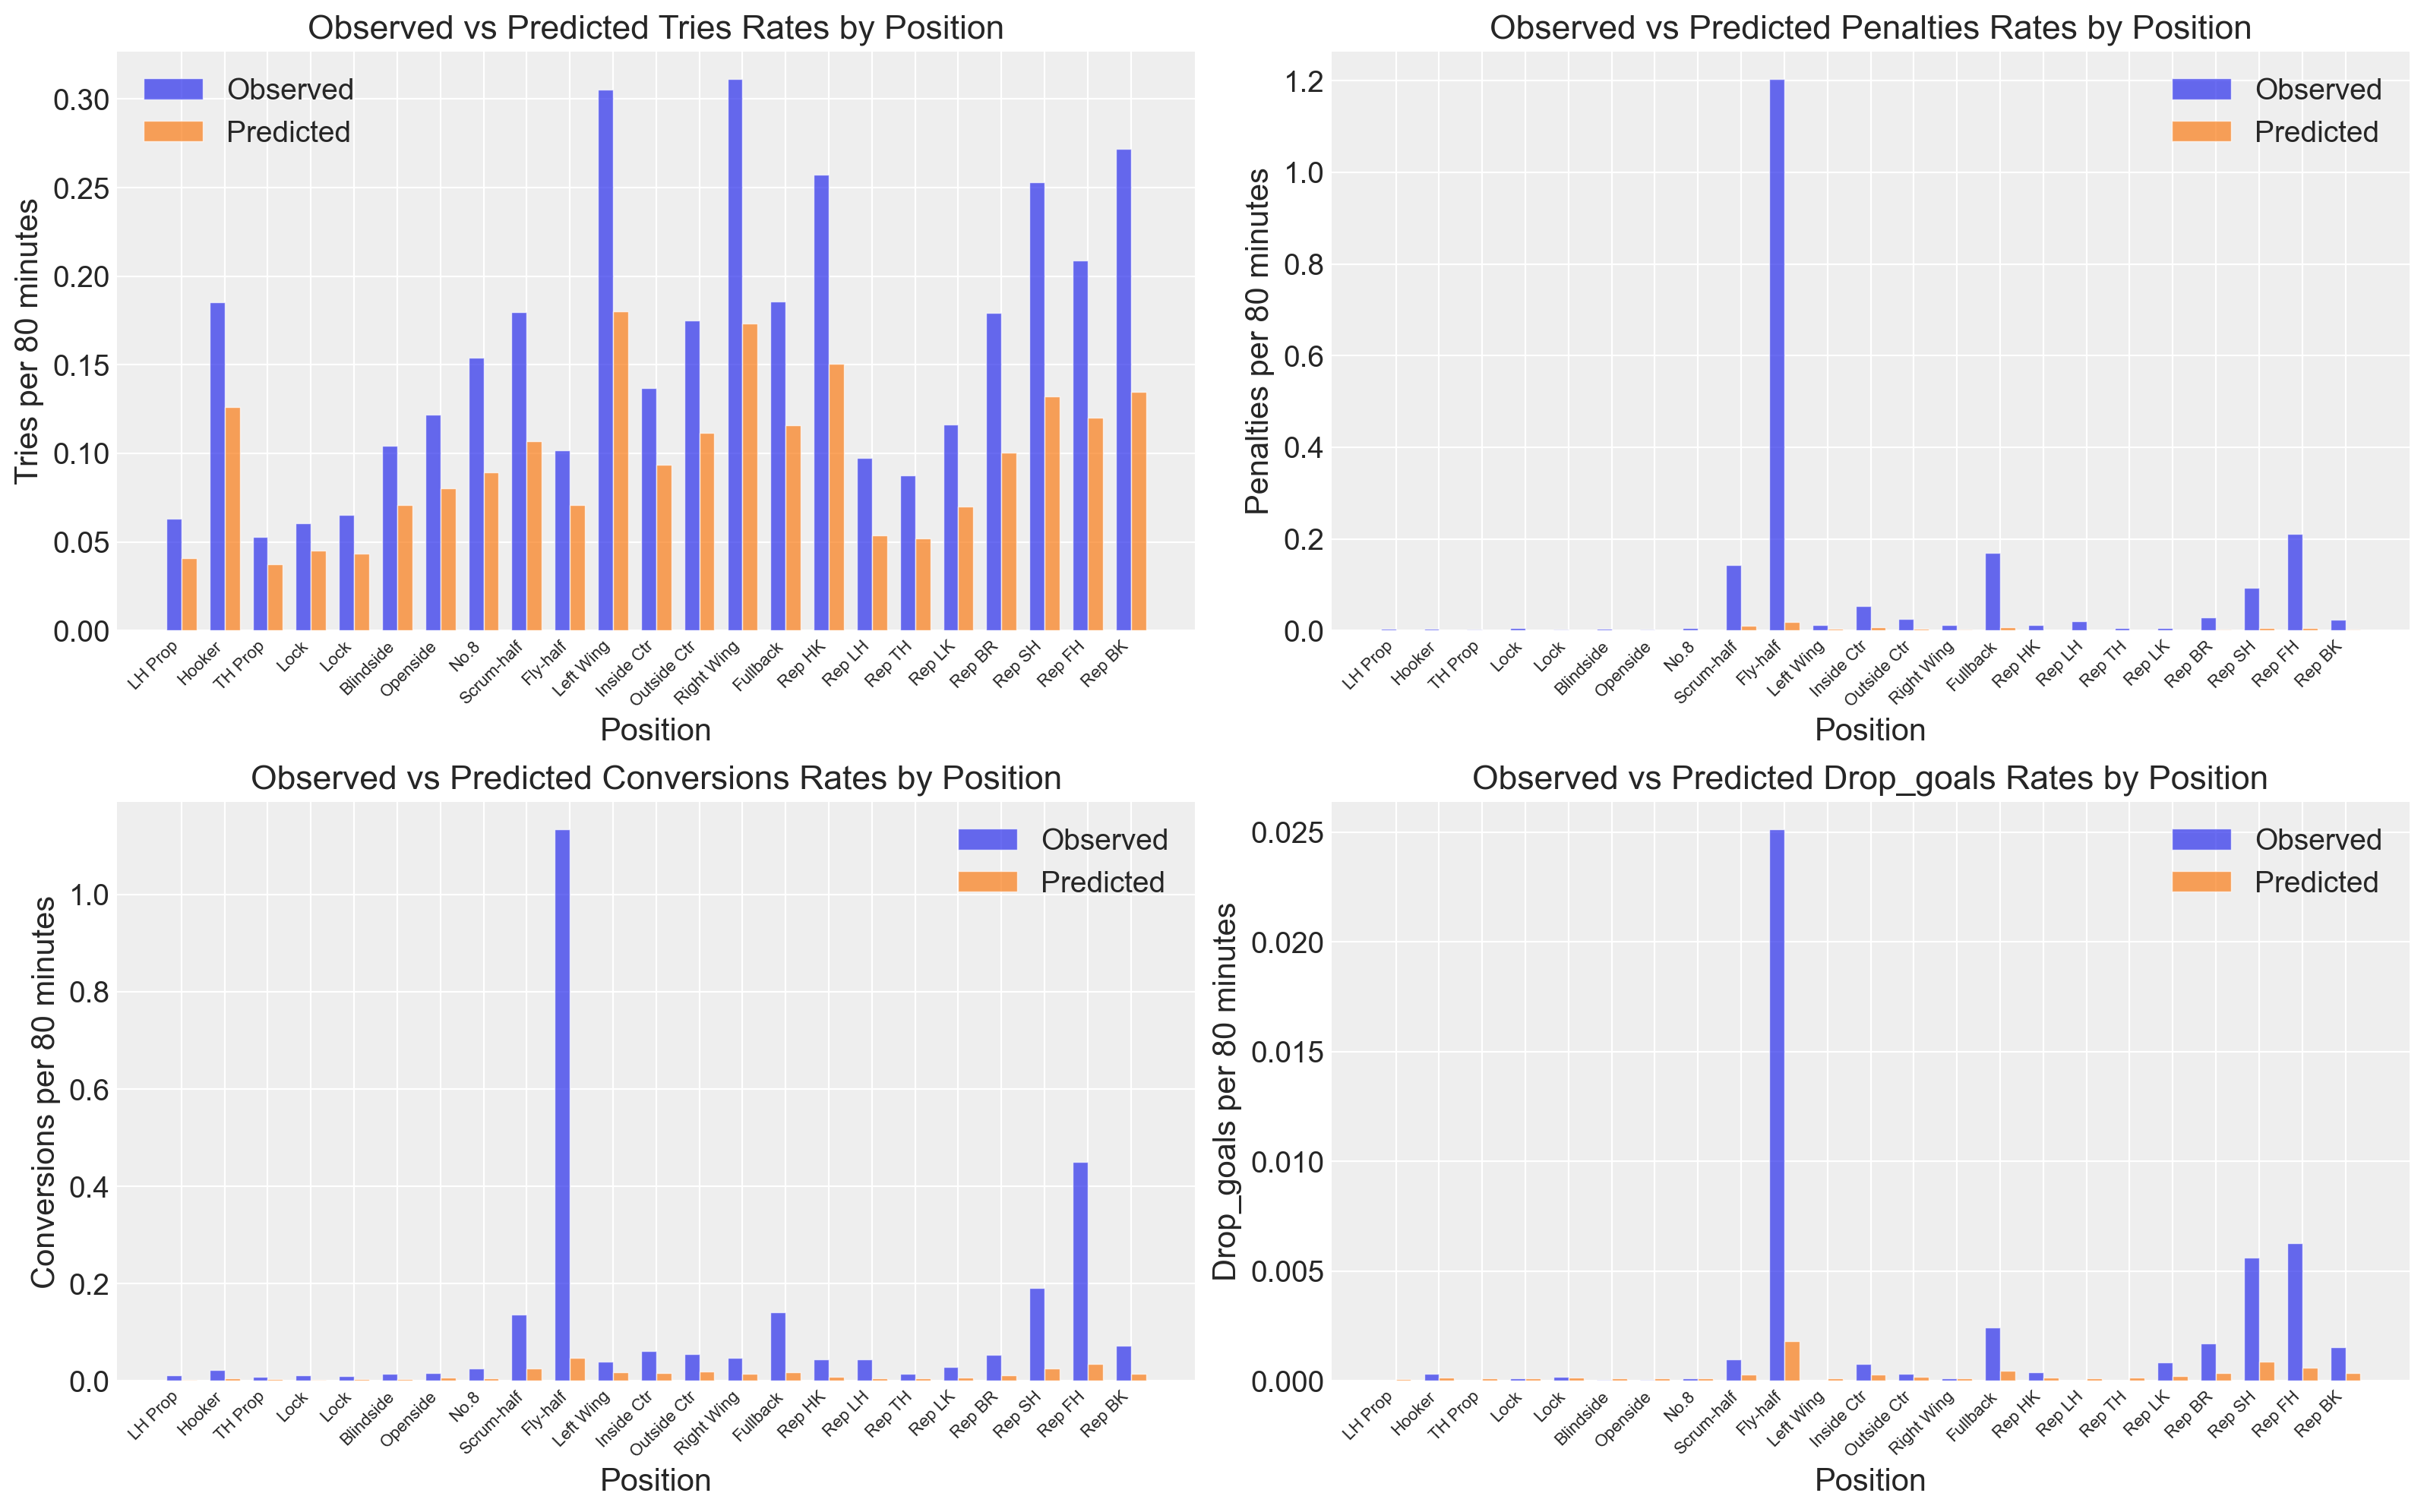

In [55]:
# Compare observed vs predicted rates by position for each score type
fig, axes = plt.subplots(2, 2, figsize=(16, 10))

for s, (st, ax) in enumerate(zip(config.score_types, axes.flat)):
    # Observed rates
    observed_rates = df.groupby('position').agg({
        st: 'sum',
        'minutes_played': 'sum'
    })
    observed_rates['rate_per_80'] = observed_rates[st] / observed_rates['minutes_played'] * 80
    
    # Get model predictions for each position
    alpha_mean = trace.posterior['alpha'].values[:, :, s].mean()
    theta_mean = trace.posterior['theta_position'].values[:, :, s, :].mean(axis=(0, 1))
    
    predicted_rate = np.exp(alpha_mean + theta_mean)
    
    positions_list = list(range(1, 24))
    x = np.arange(len(positions_list))
    width = 0.35
    
    obs_rates = [observed_rates.loc[p, 'rate_per_80'] if p in observed_rates.index else 0 
                 for p in positions_list]
    pred_rates = predicted_rate[:23]
    
    ax.bar(x - width/2, obs_rates, width, label='Observed', alpha=0.7)
    ax.bar(x + width/2, pred_rates, width, label='Predicted', alpha=0.7)
    
    ax.set_xlabel('Position')
    ax.set_ylabel(f'{st.capitalize()} per 80 minutes')
    ax.set_title(f'Observed vs Predicted {st.capitalize()} Rates by Position')
    ax.set_xticks(x)
    ax.set_xticklabels([positions.get(p, str(p)) for p in positions_list], rotation=45, ha='right', fontsize=8)
    ax.legend()

plt.tight_layout()
plt.show()

## 10. Exploring Individual Players

  Ed Byrne
Matches: 91
Total minutes: 2893 (36 full games)
Teams: Leinster Rugby, (1 BP), , Ireland, Barbarians
Seasons: ['2012-2013', '2013-2014', '2014-2015', '2015-2016', '2016-2017', '2017-2018', '2018-2019', '2019-2020', '2020-2021', '2021-2022', '2022-2023']

Scoring Summary:
------------------------------------------------------------
Score Type         Total    Rate/80     Effect             95% CI
------------------------------------------------------------
Tries                 38       1.05     +1.724 [+1.33, +2.11]
Penalties             52       1.44     +1.181 [+0.12, +4.91]
Conversions          141       3.90     +1.291 [+0.12, +5.48]
Drop_goals             0       0.00     +1.295 [+0.11, +5.47]
------------------------------------------------------------


/tmp/ipykernel_16317/3190827371.py:93: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


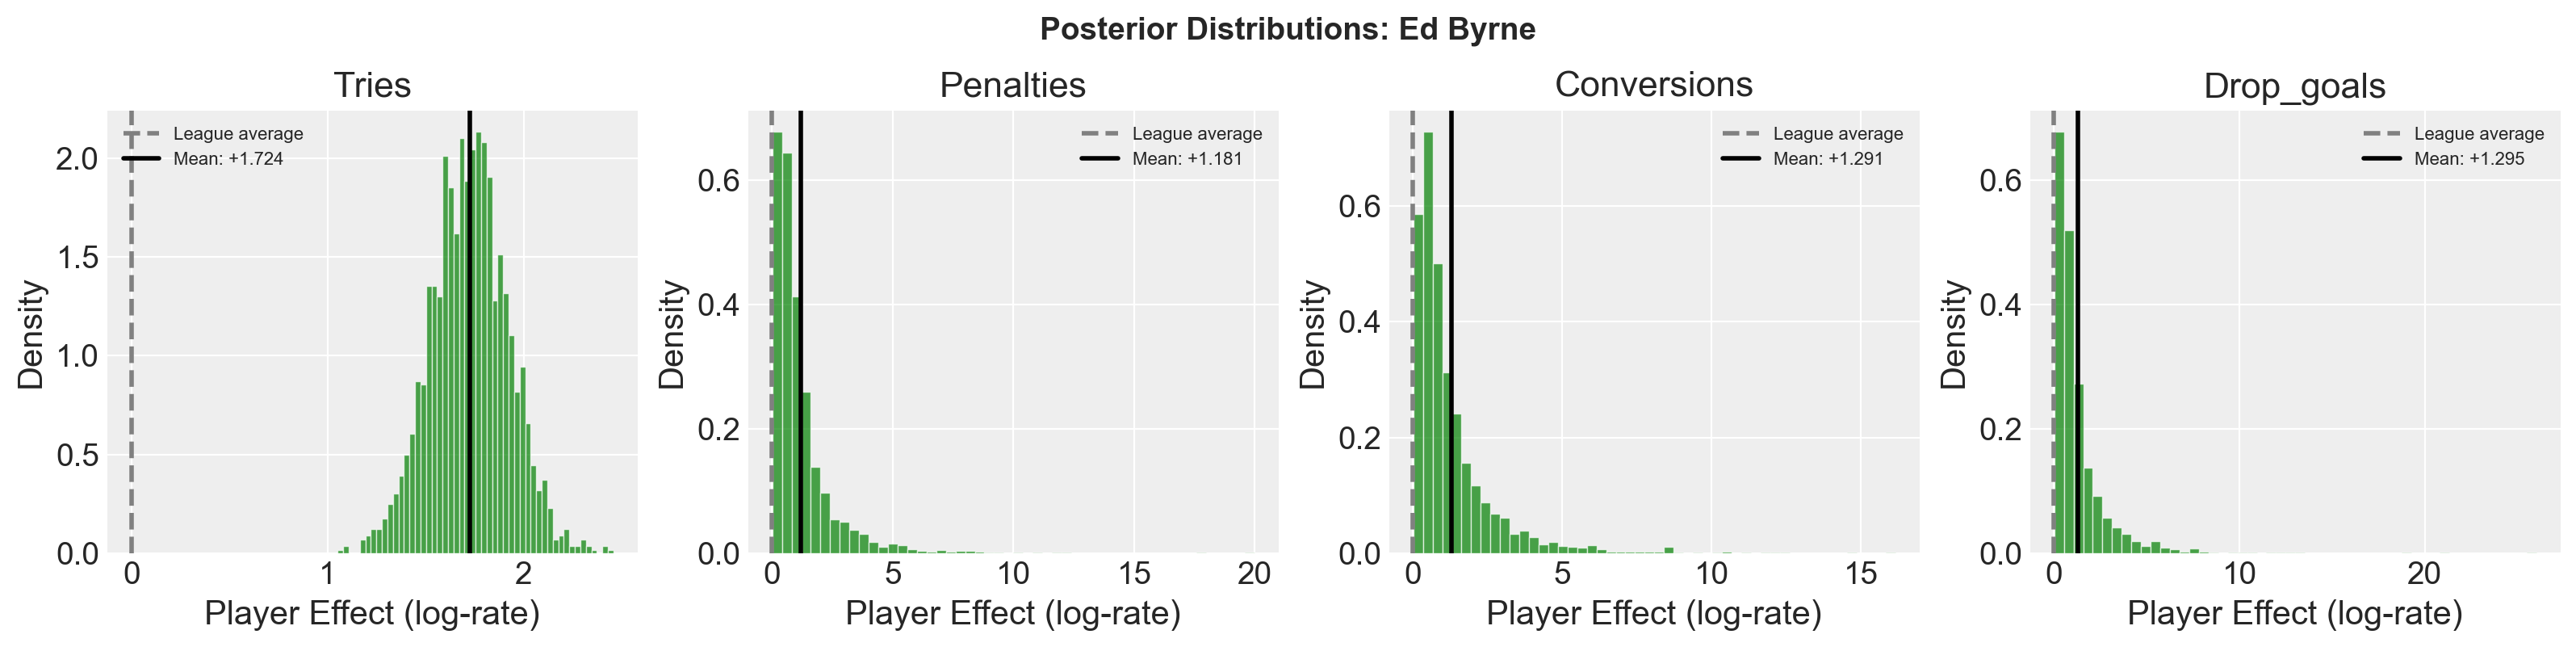

{'tries': array([[1.32372495, 1.61025689, 1.85671403, ..., 1.68116553, 1.50345115,
         1.45107444]], shape=(1, 2000)),
 'penalties': array([[1.32627641, 2.80105304, 0.83006832, ..., 1.37508941, 0.15504608,
         1.3324169 ]], shape=(1, 2000)),
 'conversions': array([[0.68193513, 3.04711446, 1.5646134 , ..., 0.74553849, 1.75888367,
         0.23336468]], shape=(1, 2000)),
 'drop_goals': array([[0.46906779, 0.60933308, 2.23156562, ..., 0.48846249, 0.20356137,
         0.36491457]], shape=(1, 2000))}

In [61]:
# Look at a specific player's history and model estimate
def analyze_player(player_name, score_type=None):
    """
    Analyze a specific player's career and model estimate.
    
    If score_type is None, shows summary for all score types.
    """
    if player_name not in model._player_ids:
        print(f"Player '{player_name}' not found in model")
        # Suggest similar names
        similar = [p for p in model._player_ids.keys() if player_name.split()[-1].lower() in p.lower()][:5]
        if similar:
            print(f"Did you mean: {similar}")
        return
    
    player_idx = model._player_ids[player_name]
    
    # Get player's match history
    player_df = df[df['player_name'] == player_name].copy()
    total_minutes = player_df['minutes_played'].sum()
    
    print(f"{'='*60}")
    print(f"  {player_name}")
    print(f"{'='*60}")
    print(f"Matches: {len(player_df)}")
    print(f"Total minutes: {total_minutes:.0f} ({total_minutes/80:.0f} full games)")
    print(f"Teams: {', '.join(player_df['team'].unique().tolist())}")
    print(f"Seasons: {sorted(player_df['season'].unique().tolist())}")
    print()
    
    # Get shared player parameters
    beta_raw = trace.posterior['beta_player_try_raw'].values[:, :, player_idx]
    sigma_player = trace.posterior['sigma_player_try'].values
    
    # Summary table for all score types
    print("Scoring Summary:")
    print("-" * 60)
    print(f"{'Score Type':<15} {'Total':>8} {'Rate/80':>10} {'Effect':>10} {'95% CI':>18}")
    print("-" * 60)
    
    effects_by_type = {}
    for s, st in enumerate(config.score_types):
        total = player_df[st].sum()
        rate = total / total_minutes * 80 if total_minutes > 0 else 0
        
        lambda_p_s = trace.posterior['lambda_player_try'].values[:, :, s]
        beta_s = sigma_player * lambda_p_s * beta_raw
        effect_mean = beta_s.mean()
        ci_low, ci_high = np.percentile(beta_s, [2.5, 97.5])
        
        effects_by_type[st] = beta_s
        
        print(f"{st.capitalize():<15} {total:>8.0f} {rate:>10.2f} {effect_mean:>+10.3f} [{ci_low:>+.2f}, {ci_high:>+.2f}]")
    
    print("-" * 60)
    
    # If a specific score type was requested, show detailed stats
    if score_type and score_type in config.score_types:
        print(f"\nDetailed {score_type} analysis:")
        beta = effects_by_type[score_type]
        print(f"  Effect mean: {beta.mean():.3f}")
        print(f"  Effect std: {beta.std():.3f}")
        
        # Percentile rank among all players
        all_effects = []
        for pid in range(len(model._player_ids)):
            b_raw = trace.posterior['beta_player_try_raw'].values[:, :, pid]
            s_idx = config.score_types.index(score_type)
            lam = trace.posterior['lambda_player_try'].values[:, :, s_idx]
            eff = (sigma_player * lam * b_raw).mean()
            all_effects.append(eff)
        
        player_rank = sum(1 for e in all_effects if e > beta.mean())
        percentile = (1 - player_rank / len(all_effects)) * 100
        print(f"  Rank: #{player_rank + 1} of {len(all_effects)} ({percentile:.0f}th percentile)")
    
    # Plot posterior for all score types
    fig, axes = plt.subplots(1, len(config.score_types), figsize=(16, 4))
    for s, (st, ax) in enumerate(zip(config.score_types, axes)):
        beta_s = effects_by_type[st]
        
        color = 'green' if beta_s.mean() > 0 else 'red'
        ax.hist(beta_s.flatten(), bins=50, density=True, alpha=0.7, color=color)
        ax.axvline(x=0, color='gray', linestyle='--', linewidth=2, label='League average')
        ax.axvline(x=beta_s.mean(), color='black', linestyle='-', linewidth=2, 
                   label=f'Mean: {beta_s.mean():+.3f}')
        ax.set_xlabel('Player Effect (log-rate)')
        ax.set_ylabel('Density')
        ax.set_title(f'{st.capitalize()}')
        ax.legend(fontsize=8)
    
    plt.suptitle(f'Posterior Distributions: {player_name}', fontsize=14, fontweight='bold')
    plt.tight_layout()
    plt.show()
    
    return effects_by_type

# Example: analyze top try-scorer
top_player = try_rankings.iloc[0]['player']
analyze_player(top_player)

In [62]:
# Look at a specific player's history and model estimate
def analyze_player(player_name, score_type=None):
    """
    Analyze a specific player's career and model estimate.
    
    If score_type is None, shows summary for all score types.
    Correctly handles separate try-scoring vs kicking effects.
    """
    if player_name not in model._player_ids:
        print(f"Player '{player_name}' not found in model")
        # Suggest similar names
        similar = [p for p in model._player_ids.keys() if player_name.split()[-1].lower() in p.lower()][:5]
        if similar:
            print(f"Did you mean: {similar}")
        return
    
    player_idx = model._player_ids[player_name]
    
    # Get player's match history
    player_df = df[df['player_name'] == player_name].copy()
    total_minutes = player_df['minutes_played'].sum()
    
    print(f"{'='*60}")
    print(f"  {player_name}")
    print(f"{'='*60}")
    print(f"Matches: {len(player_df)}")
    print(f"Total minutes: {total_minutes:.0f} ({total_minutes/80:.0f} full games)")
    print(f"Teams: {', '.join(player_df['team'].unique().tolist())}")
    print(f"Seasons: {sorted(player_df['season'].unique().tolist())}")
    print()
    
    # Check if model has separate effects
    has_separate = 'beta_player_try_raw' in trace.posterior
    
    if has_separate:
        # Get separate parameters for try-scoring vs kicking
        beta_try_raw = trace.posterior['beta_player_try_raw'].values[:, :, player_idx]
        beta_kick_raw = trace.posterior['beta_player_kick_raw'].values[:, :, player_idx]
        sigma_player_try = trace.posterior['sigma_player_try'].values
        sigma_player_kick = trace.posterior['sigma_player_kick'].values
    else:
        # Single player effect (old model)
        beta_raw = trace.posterior['beta_player_raw'].values[:, :, player_idx]
        sigma_player = trace.posterior['sigma_player'].values
    
    # Summary table for all score types
    print("Scoring Summary:")
    print("-" * 60)
    print(f"{'Score Type':<15} {'Total':>8} {'Rate/80':>10} {'Effect':>10} {'95% CI':>18}")
    print("-" * 60)
    
    effects_by_type = {}
    for s, st in enumerate(config.score_types):
        total = player_df[st].sum()
        rate = total / total_minutes * 80 if total_minutes > 0 else 0
        
        # Use appropriate effect based on score type
        if has_separate:
            if st == 'tries':
                # Try-scoring effect
                lambda_p_s = trace.posterior['lambda_player_try'].values[:, :, s]
                beta_s = sigma_player_try[:, :, None] * lambda_p_s[:, :, None] * beta_try_raw
            else:
                # Kicking effect (penalties, conversions, drop_goals)
                lambda_p_s = trace.posterior['lambda_player_kick'].values[:, :, s]
                beta_s = sigma_player_kick[:, :, None] * lambda_p_s[:, :, None] * beta_kick_raw
        else:
            # Single effect
            lambda_p_s = trace.posterior['lambda_player'].values[:, :, s]
            beta_s = sigma_player[:, :, None] * lambda_p_s[:, :, None] * beta_raw
        
        effect_mean = beta_s.mean()
        ci_low, ci_high = np.percentile(beta_s, [2.5, 97.5])
        
        effects_by_type[st] = beta_s
        
        print(f"{st.capitalize():<15} {total:>8.0f} {rate:>10.2f} {effect_mean:>+10.3f} [{ci_low:>+.2f}, {ci_high:>+.2f}]")
    
    print("-" * 60)
    
    # If a specific score type was requested, show detailed stats
    if score_type and score_type in config.score_types:
        print(f"\nDetailed {score_type} analysis:")
        beta = effects_by_type[score_type]
        print(f"  Effect mean: {beta.mean():.3f}")
        print(f"  Effect std: {beta.std():.3f}")
        
        # Percentile rank among all players
        s_idx = config.score_types.index(score_type)
        all_effects = []
        for pid in range(len(model._player_ids)):
            if has_separate:
                if score_type == 'tries':
                    b_raw = trace.posterior['beta_player_try_raw'].values[:, :, pid]
                    sig = sigma_player_try
                    lam = trace.posterior['lambda_player_try'].values[:, :, s_idx]
                else:
                    b_raw = trace.posterior['beta_player_kick_raw'].values[:, :, pid]
                    sig = sigma_player_kick
                    lam = trace.posterior['lambda_player_kick'].values[:, :, s_idx]
                eff = (sig[:, :, None] * lam[:, :, None] * b_raw).mean()
            else:
                b_raw = trace.posterior['beta_player_raw'].values[:, :, pid]
                lam = trace.posterior['lambda_player'].values[:, :, s_idx]
                eff = (sigma_player[:, :, None] * lam[:, :, None] * b_raw).mean()
            all_effects.append(eff)
        
        player_rank = sum(1 for e in all_effects if e > beta.mean())
        percentile = (1 - player_rank / len(all_effects)) * 100
        print(f"  Rank: #{player_rank + 1} of {len(all_effects)} ({percentile:.0f}th percentile)")
    
    # Plot posterior for all score types
    fig, axes = plt.subplots(1, len(config.score_types), figsize=(16, 4))
    for s, (st, ax) in enumerate(zip(config.score_types, axes)):
        beta_s = effects_by_type[st]
        
        color = 'green' if beta_s.mean() > 0 else 'red'
        ax.hist(beta_s.flatten(), bins=50, density=True, alpha=0.7, color=color)
        ax.axvline(x=0, color='gray', linestyle='--', linewidth=2, label='League average')
        ax.axvline(x=beta_s.mean(), color='black', linestyle='-', linewidth=2, 
                   label=f'Mean: {beta_s.mean():+.3f}')
        ax.set_xlabel('Player Effect (log-rate)')
        ax.set_ylabel('Density')
        ax.set_title(f'{st.capitalize()}')
        ax.legend(fontsize=8)
    
    plt.suptitle(f'Posterior Distributions: {player_name}', fontsize=14, fontweight='bold')
    plt.tight_layout()
    plt.show()
    
    return effects_by_type

# Example: analyze top try-scorer
top_player = try_rankings.iloc[0]['player']
analyze_player(top_player)

Players matching 'van der': ['Akker van der Merwe', 'Andrew van der Heijden', 'Archie van der Flier', 'Armand van der Merwe', 'Bernard van der Linde', 'CJ van der Linde', 'Christiaan Van der Merwe', 'Christie van der Merwe', 'Christo van der Merwe', 'Christoffel van der Walt', 'Crisjan Van der Westhuyzen', 'D. T. H. van der Merwe', 'Daan van der Avoird', 'Danie van der Merwe', 'Dayan van der Westhuizen', 'Delano Jansen van der Sligte', 'Duhan Van Der Merwe', 'Duhan van der Merwe', 'Edwill van der Merwe', 'Ewald Van Der Westhuizen']


  Dan Carter
Matches: 40
Total minutes: 2980 (37 full games)
Teams: , New Zealand
Seasons: ['2006-2007', '2009-2010', '2010-2011', '2012-2013', '2013-2014', '2014-2015', '2015-2016', 'cup-2007', 'cup-2011', 'cup-2015']

Scoring Summary:
------------------------------------------------------------
Score Type         Total    Rate/80     Effect             95% CI
------------------------------------------------------------
Tries                  5       0.13     +0.161 [-0.53, +0.83]
Penalties             76       2.04     +0.119 [-0.47, +1.11]
Conversions            5       0.13     +0.114 [-0.50, +1.09]
Drop_goals             0       0.00     +0.131 [-0.37, +1.20]
------------------------------------------------------------


/tmp/ipykernel_16317/3190827371.py:93: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


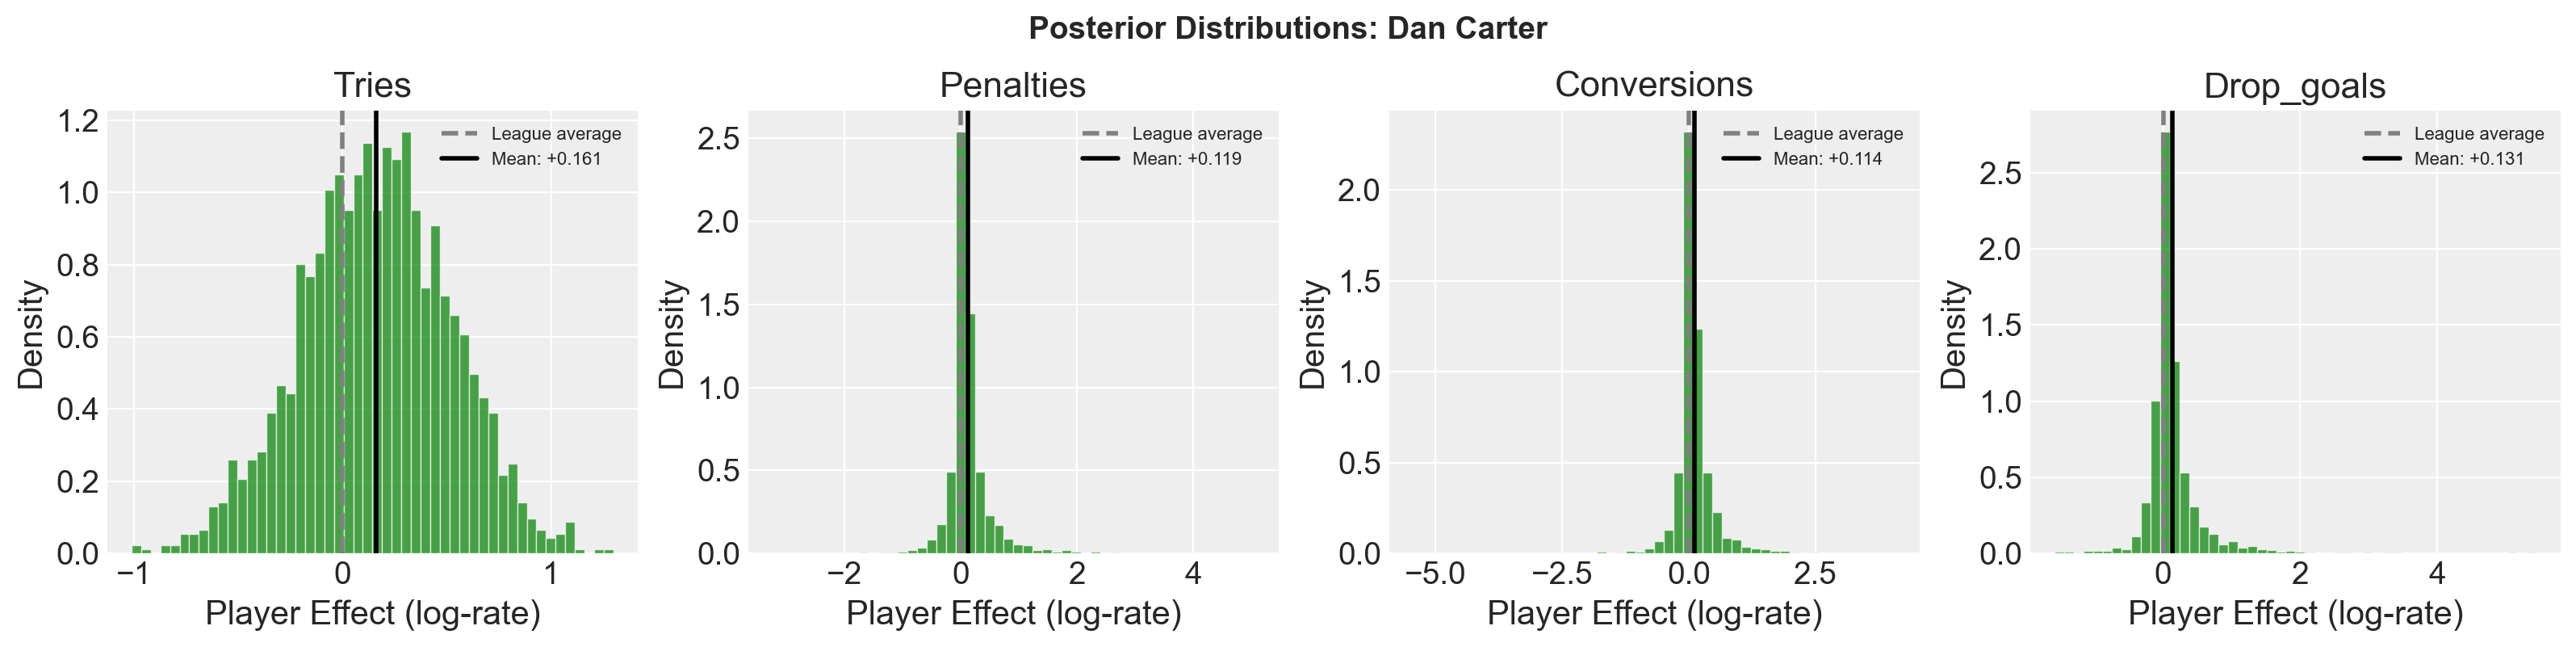

In [64]:
for player in search_players("Dan Carter"):
    analyze_player(player)

Known kickers found: ['Andy Farrell', 'Chris Farrell', 'Farrell', 'Owen Farrell', 'Thomas Farrell']
  Andy Farrell
Matches: 33
Total minutes: 2279 (28 full games)
Teams: Saracens
Seasons: ['2006-2007', '2007-2008', '2008-2009']

Scoring Summary:
------------------------------------------------------------
Score Type         Total    Rate/80     Effect             95% CI
------------------------------------------------------------
Tries                  0       0.00     -0.026 [-0.35, +0.30]
Penalties              0       0.00     -0.345 [-4.79, +3.92]
Conversions            0       0.00     -0.311 [-4.31, +3.52]
Drop_goals             0       0.00     -0.207 [-2.87, +2.36]
------------------------------------------------------------


/tmp/ipykernel_18136/276340776.py:93: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


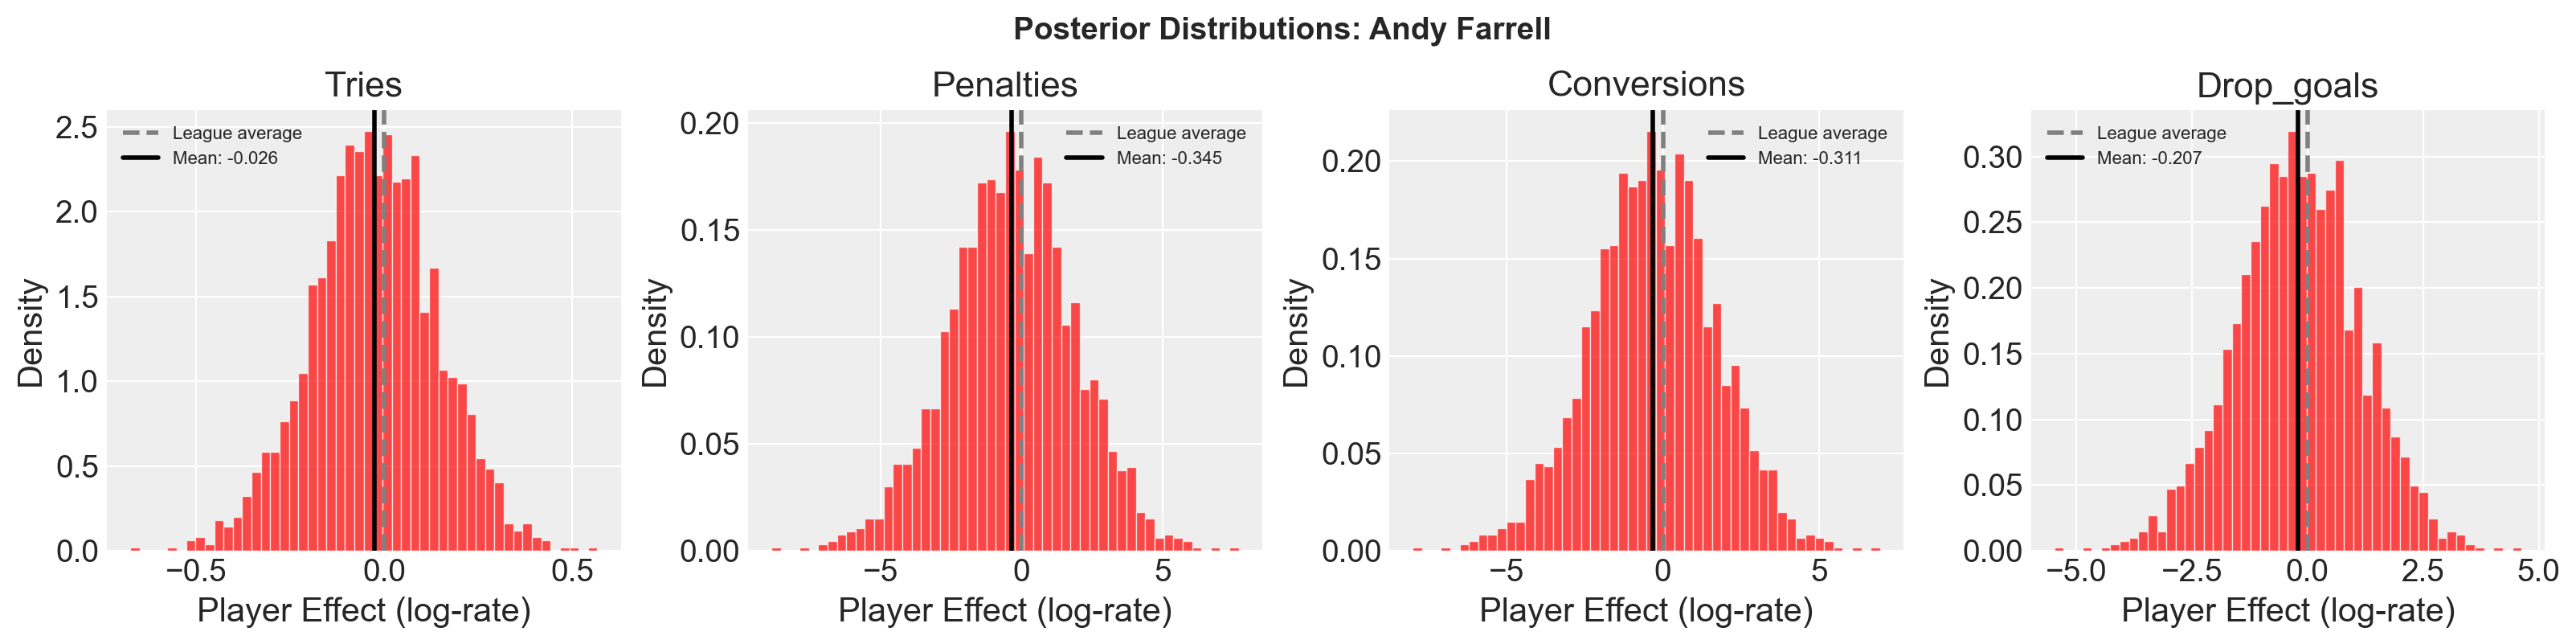

In [ ]:
# Analyze known kickers - use actual kickers from dataset
# These are players who have penalties or conversions on record

kicker_list = find_kickers(min_kicks=20)  # Players with 20+ kicks
kicker_names = kicker_list.index.tolist()[:10]  # Top 10 kickers

print(f"Analyzing {len(kicker_names)} actual kickers:")
print(kicker_names)

if kicker_names:
    # Show full profile for the first kicker
    analyze_player(kicker_names[0], score_type='penalties')


Player Comparison (Effect Means):


,tries,penalties,conversions,drop_goals
Player,,,,
Andy Farrell,-0.026,-0.345,-0.311,-0.207
Chris Farrell,-0.297,-3.996,-3.603,-2.395
Farrell,-0.046,-0.623,-0.562,-0.373


/tmp/ipykernel_18136/55677004.py:56: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


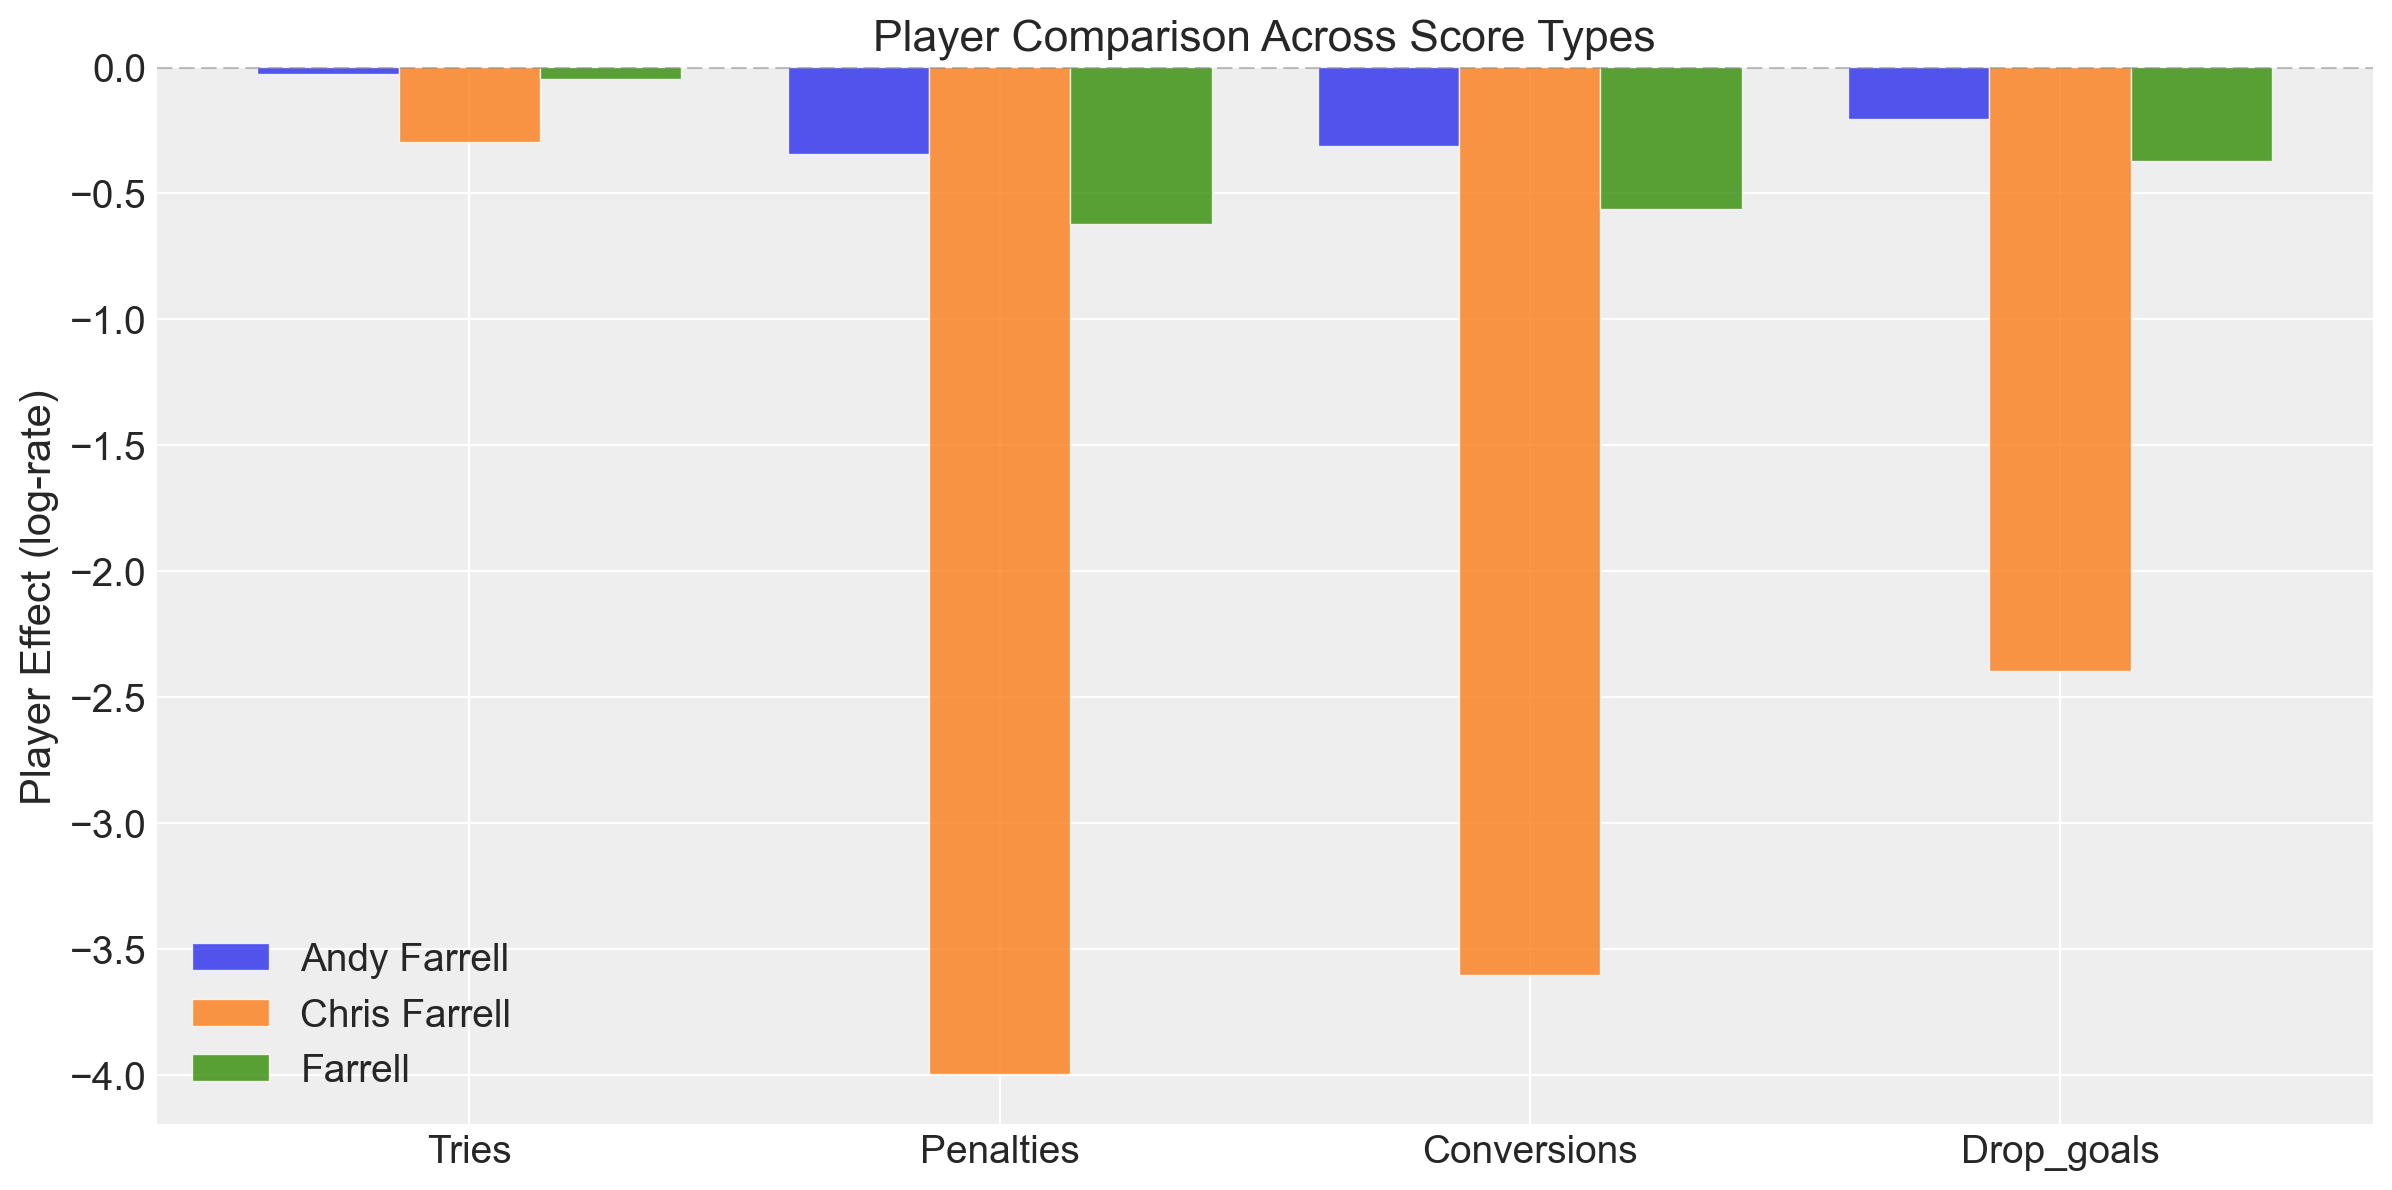

In [ ]:
# Compare multiple players across score types
def compare_players(player_names, score_types=None):
    """
    Compare multiple players across specified (or all) score types.
    """
    if score_types is None:
        score_types = config.score_types
    
    # Filter to valid players
    valid_players = [p for p in player_names if p in model._player_ids]
    if not valid_players:
        print("No valid players found")
        return
    
    sigma_player = trace.posterior['sigma_player'].values
    
    # Collect effects for each player
    player_effects = {}
    for player_name in valid_players:
        player_idx = model._player_ids[player_name]
        beta_raw = trace.posterior['beta_player_raw'].values[:, :, player_idx]
        
        effects = {}
        for s, st in enumerate(config.score_types):
            if st in score_types:
                lambda_p_s = trace.posterior['lambda_player'].values[:, :, s]
                beta_s = sigma_player * lambda_p_s * beta_raw
                effects[st] = beta_s.mean()
        player_effects[player_name] = effects
    
    # Create comparison dataframe
    comparison_df = pd.DataFrame(player_effects).T
    comparison_df.index.name = 'Player'
    
    print("Player Comparison (Effect Means):")
    display(comparison_df.round(3))
    
    # Visualize
    fig, ax = plt.subplots(figsize=(12, 6))
    
    x = np.arange(len(score_types))
    width = 0.8 / len(valid_players)
    
    for i, player in enumerate(valid_players):
        effects = [player_effects[player].get(st, 0) for st in score_types]
        offset = (i - len(valid_players)/2 + 0.5) * width
        bars = ax.bar(x + offset, effects, width, label=player, alpha=0.8)
    
    ax.set_xticks(x)
    ax.set_xticklabels([st.capitalize() for st in score_types])
    ax.set_ylabel('Player Effect (log-rate)')
    ax.set_title('Player Comparison Across Score Types')
    ax.axhline(y=0, color='gray', linestyle='--', alpha=0.5)
    ax.legend(loc='best')
    
    plt.tight_layout()
    plt.show()
    
    return comparison_df

# Compare top kickers
if len(kickers) >= 2:
    compare_players(kickers[:3])